# Insurance Claims - Data Processing and Modelling 

<div style="background-color:lightblue; padding:10px;"

## Overview

1. Load packages
2. Preprocessing
3. Label encoding of target (fraud= 1/non-fraud=0)
4. Ordinal Encoding 'incident_severity'
5. Train/Test Split
    - Imbalance and metric
6. Modelling - Common models with the imbalanced data set
7. Resampling the train set
    - RandomOverSampler
    - Smote Tomek
8. Lazy Predictor on resampled sets
9. Features importance on LDA with SmoteTomek
10. Gridsearches / Hyperparameter Optimization Smote Tomek
11. Stratified K-Fold Cross Validation
12. Voting Classifier


## 1. Load packages

In [4]:
#Load standard packages
import pandas as pd
import numpy as np

#Load data vizualization packages
import matplotlib.pyplot as plt

#Load  data processing packages
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek


#Load classifier for modelling
from lazypredict.Supervised import LazyClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier

#Load ensemble classifier for modelling
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

#Load packages for model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV


#Load packages for model evaluation
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

## 2. Preprocessing 

In [5]:
#import
df=pd.read_csv("insurance_claims.csv", parse_dates=["policy_bind_date", "incident_date"], index_col="policy_number")
#check duplicates
print('Duplicated: ', df.duplicated().sum() )
print('\n')
#ensure consistency on column names 
rename ={'capital-gains':'capital_gains','capital-loss': 'capital_loss'}
df.rename(columns=rename, inplace=True)
#Rename Strings from '?' to 'Unkown'
df["collision_type"]=df["collision_type"].apply(lambda x: "No Collision" if str(x)=="?" else x)
df["police_report_available"]=df["police_report_available"].apply(lambda x: "Unknown" if str(x)=="?" else x)
df["property_damage"]=df["property_damage"].apply(lambda x: "Unknown" if str(x)=="?" else x)

# drop column as 100% nan-values
# drop umbrella limits as 80% of values are zeros, std = 1.1 Mio
# drop columns where p_value <5% or highly correlated with other variables
# drop columns with high correlation 
col_drop =['months_as_customer',  'umbrella_limit',  'total_claim_amount', '_c39','age','policy_bind_date','policy_state', 'policy_csl','policy_deductable',
           'policy_annual_premium','insured_zip','insured_sex','insured_education_level','insured_occupation','insured_relationship','capital_gains','capital_loss',
           'incident_date','incident_city','incident_location','incident_hour_of_the_day','number_of_vehicles_involved','bodily_injuries',
           'witnesses','police_report_available','injury_claim','property_claim','auto_make','auto_model','auto_year']
df.drop(col_drop,axis=1,inplace= True)
#check columns
print('Remaining features: ', df.columns)
print('\n')
print('Missing values: ', df.isna().sum().sum() , 'in the variable authorities_contacted, ' \
'they will be replaced after the train/test split with the most_frequent value using the SimpleImputer.')
print('\n')
print(df.info())
df.head()


Duplicated:  0


Remaining features:  Index(['insured_hobbies', 'incident_type', 'collision_type',
       'incident_severity', 'authorities_contacted', 'incident_state',
       'property_damage', 'vehicle_claim', 'fraud_reported'],
      dtype='object')


Missing values:  91 in the variable authorities_contacted, they will be replaced after the train/test split with the most_frequent value using the SimpleImputer.


<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 521585 to 556080
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   insured_hobbies        1000 non-null   object
 1   incident_type          1000 non-null   object
 2   collision_type         1000 non-null   object
 3   incident_severity      1000 non-null   object
 4   authorities_contacted  909 non-null    object
 5   incident_state         1000 non-null   object
 6   property_damage        1000 non-null   object
 7   vehicle_

,insured_hobbies,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,property_damage,vehicle_claim,fraud_reported
policy_number,,,,,,,,,
521585,sleeping,Single Vehicle Collision,Side Collision,Major Damage,Police,SC,YES,52080,Y
342868,reading,Vehicle Theft,No Collision,Minor Damage,Police,VA,Unknown,3510,Y
687698,board-games,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,NY,NO,23100,N
227811,board-games,Single Vehicle Collision,Front Collision,Major Damage,Police,OH,Unknown,50720,Y
367455,board-games,Vehicle Theft,No Collision,Minor Damage,NaN,NY,NO,4550,N


## 3. Label encoding of target (fraud= 1/non-fraud=0)

In [6]:
LabelEnc = LabelEncoder()
df['fraud_reported'] = LabelEnc.fit_transform(df['fraud_reported'])
#labels: 0 = No Fraud, 1 = Fraud

## 4. Ordinal Encoding 'incident_severity' (Step has been skipped)

In [7]:
#Ordinal categorical variable - Use the ordinal encoder to encode
#ord_cat_var = ['incident_severity']
#severity_order = [['Trivial Damage', 'Minor Damage', 'Major Damage', 'Total Loss']]
#ordinal_enc = OrdinalEncoder(categories=severity_order)
#df['incident_severity'] = ordinal_enc.fit_transform(df[['incident_severity']])

#df.head()

## 5.  Train Test Split

In [8]:
#X / y split
X=df.drop('fraud_reported', axis=1)
y=df['fraud_reported']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Train Set: ' , X_train.shape)
print('Test Set: ' , X_test.shape)

#missing values treatment with SIMPLE IMPUTER
#define numerical and categorical columns
categorical_columns=['authorities_contacted']
# instantiate imputers
categorical_imputer=SimpleImputer(strategy='most_frequent')
#apply to categorical columns
X_train[categorical_columns]=categorical_imputer.fit_transform(X_train[categorical_columns])
X_test[categorical_columns]=categorical_imputer.transform(X_test[categorical_columns])


# Nominal-categorical variables; one-hot encoding is preferred in this case

# Resetting the index
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False) #sparse_output=False
# Select only the nominal var columns for encoding
#columns_to_encode = ['insured_hobbies', 'incident_type', 'collision_type', 'authorities_contacted', 'incident_state']
columns_to_encode = ['insured_hobbies', 'incident_type', 'collision_type', 'authorities_contacted', 'incident_state', 'incident_severity','property_damage',]
# Fit the encoder on the training set and transform both the training and test sets
encoder.fit(X_train[columns_to_encode])
# Encode the nominal vars columns for both datasets
X_train_encoded = encoder.transform(X_train[columns_to_encode])
X_test_encoded = encoder.transform(X_test[columns_to_encode])

# Convert the encoded arrays to DataFrames
train_encoded_df = pd.DataFrame(X_train_encoded, index=X_train.index, columns=encoder.get_feature_names_out(columns_to_encode)) #index=X_train.index
test_encoded_df = pd.DataFrame(X_test_encoded, index=X_test.index, columns=encoder.get_feature_names_out(columns_to_encode)) #index=X_test.index

# Drop the original nominal vars column and concatenate the new encoded columns
X_train = pd.concat([X_train.drop(columns=columns_to_encode), train_encoded_df], axis=1)
X_test = pd.concat([X_test.drop(columns=columns_to_encode), test_encoded_df], axis=1)


print('Train Set after OHE: ' , X_train.shape)
print('Test Set after OHE: ' , X_test.shape)


#Scaling (normalization) of numerical variables
minmax_scaler = MinMaxScaler()
minmax_col = ['vehicle_claim']
for column in minmax_col:
    X_train[column] = minmax_scaler.fit_transform(X_train[[column]])
    X_test[column] = minmax_scaler.transform(X_test[[column]])

X_train.head()

Train Set:  (800, 8)
Test Set:  (200, 8)
Train Set after OHE:  (800, 47)
Test Set after OHE:  (200, 47)


,vehicle_claim,insured_hobbies_base-jumping,insured_hobbies_basketball,insured_hobbies_board-games,insured_hobbies_bungie-jumping,insured_hobbies_camping,insured_hobbies_chess,insured_hobbies_cross-fit,insured_hobbies_dancing,insured_hobbies_exercise,...,incident_state_SC,incident_state_VA,incident_state_WV,incident_severity_Major Damage,incident_severity_Minor Damage,incident_severity_Total Loss,incident_severity_Trivial Damage,property_damage_NO,property_damage_Unknown,property_damage_YES
0,0.80,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00
1,0.49,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00
2,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00
3,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00
4,0.71,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00


<div style="background-color:lightblue; padding:10px;"

### Imbalance & Metric
- Due to the imbalanced nature of our dataset we will resample our dataset, trying different techniques.

**Metric**
- Focus will be on the F1 Score and Recall. 
- Greater focus on the F1 score for our target = 1 (fraud positive) 



In [9]:
# value counts y
y_train.value_counts(normalize=True)


fraud_reported
0   0.76
1   0.24
Name: proportion, dtype: float64

## 6. Modelling - Common models with the imbalanced data set

<div style="background-color:lightblue; padding:10px;"

### - Best models before resampling: 
- LDA and Ridge
    - small overfitting
    - best F1 scores


</div>


F1 Scores and Differences:


,Model,Train F1 (weighted),Test F1 (weighted),F1 (weighted) Difference,Train F1 (pos. class),Test F1 (pos. class),F1 Difference (pos. class)
0,Logistic Regression,0.88,0.83,0.05,0.74,0.68,0.05
1,SVC,0.90,0.80,0.10,0.80,0.64,0.16
2,Ridge Classifier,0.88,0.85,0.03,0.75,0.74,0.01
3,Linear Discriminant Analysis,0.88,0.84,0.03,0.76,0.74,0.01
4,Decision Tree,1.00,0.78,0.22,1.00,0.61,0.39
5,Random Forest,1.00,0.81,0.19,1.00,0.64,0.36
6,AdaBoost,0.84,0.78,0.05,0.64,0.59,0.05
7,XGBoost,1.00,0.81,0.19,1.00,0.63,0.37


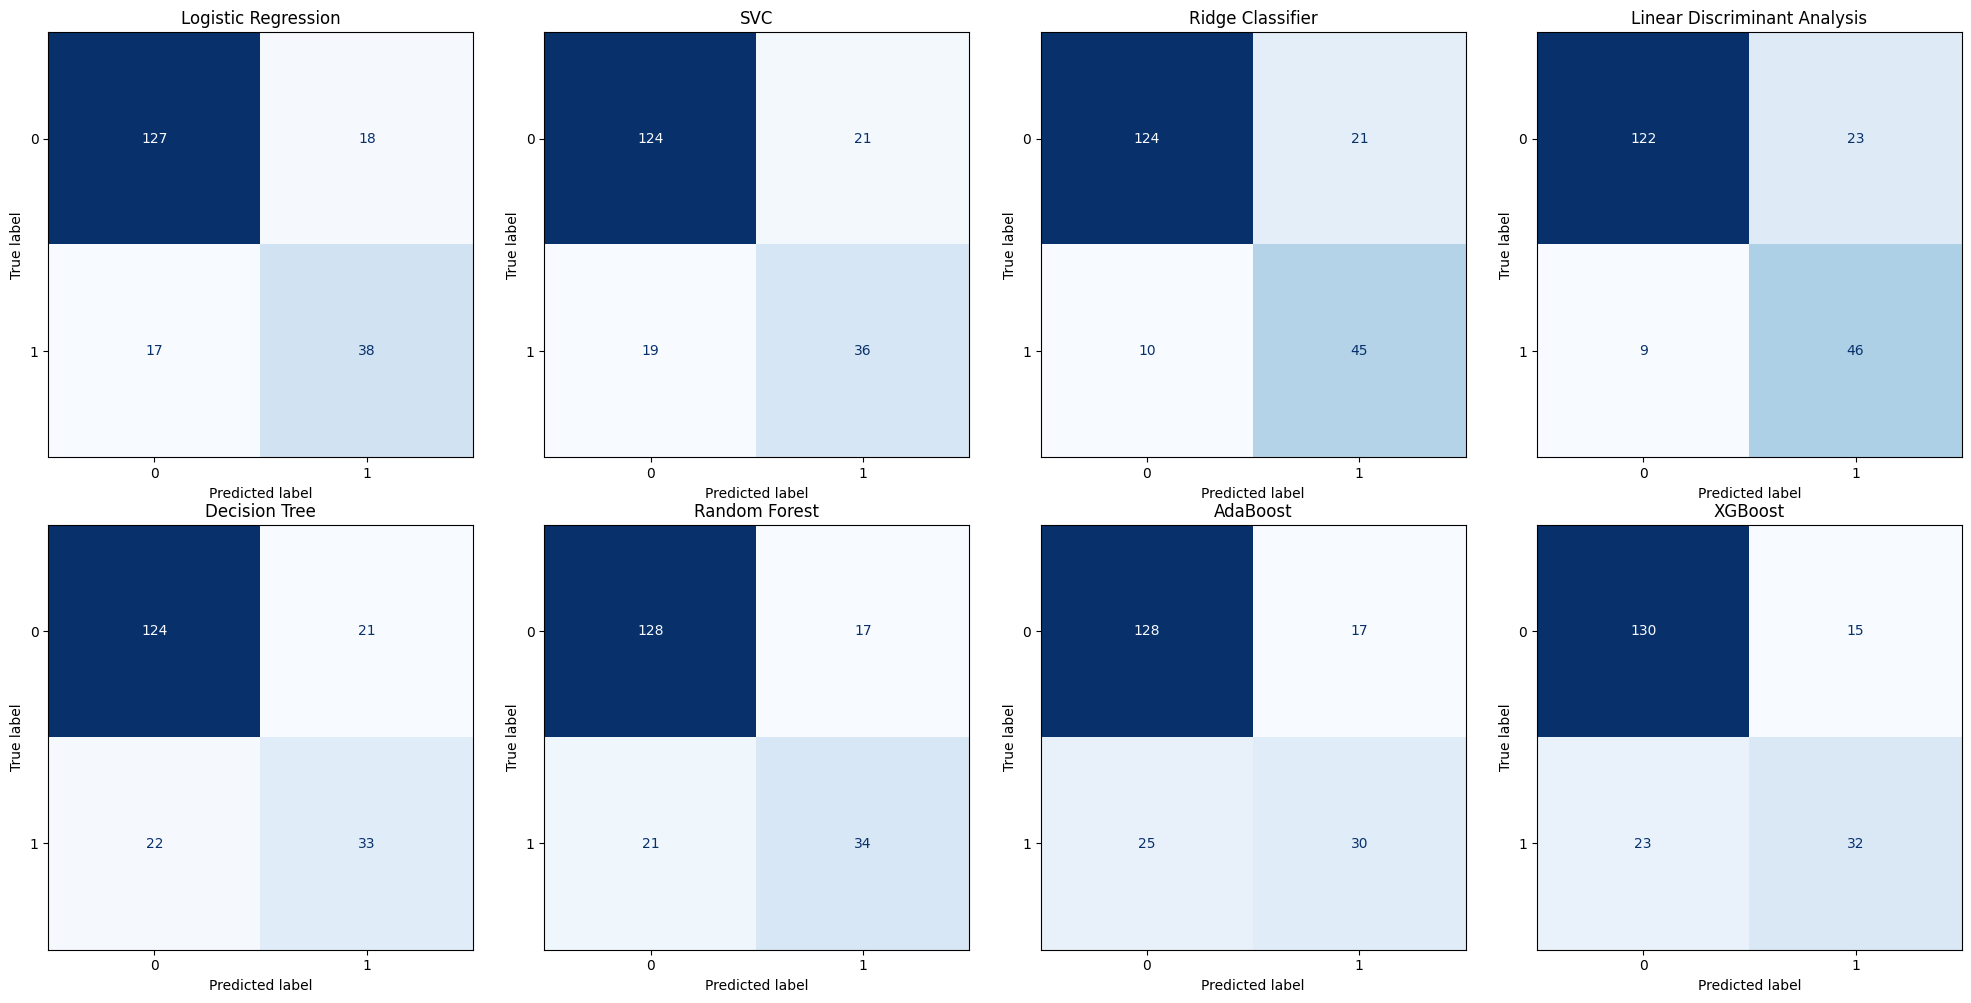



       Classification Report for Logistic Regression        
              precision  recall  f1-score  support
0                  0.88    0.88      0.88   145.00
1                  0.68    0.69      0.68    55.00
accuracy           0.82    0.82      0.82     0.82
macro avg          0.78    0.78      0.78   200.00
weighted avg       0.83    0.82      0.83   200.00


               Classification Report for SVC                
              precision  recall  f1-score  support
0                  0.87    0.86      0.86   145.00
1                  0.63    0.65      0.64    55.00
accuracy           0.80    0.80      0.80     0.80
macro avg          0.75    0.75      0.75   200.00
weighted avg       0.80    0.80      0.80   200.00


         Classification Report for Ridge Classifier         
              precision  recall  f1-score  support
0                  0.93    0.86      0.89   145.00
1                  0.68    0.82      0.74    55.00
accuracy           0.84    0.84      0.84     

In [10]:

# Models and their full names
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'SVC': SVC(random_state=42),
    'Ridge Classifier': RidgeClassifier(random_state=42),
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42)
}

results = []
confusion_matrices = {}
classification_reports = {}

for model_name, model in models.items():
    # Train the model once
    model.fit(X_train, y_train)

    # Make predictions once
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    # Calculate F1 scores
    test_f1 = f1_score(y_test, y_pred_test)
    train_f1 = f1_score(y_train, y_pred_train)
    test_f1_weighted = f1_score(y_test, y_pred_test, average='weighted')
    train_f1_weighted = f1_score(y_train, y_pred_train, average='weighted')

    # Calculate the difference in scores
    f1_diff = train_f1 - test_f1
    f1_weighted_diff = train_f1_weighted - test_f1_weighted

    results.append({
        'Model': model_name,
        'Train F1 (weighted)': train_f1_weighted,
        'Test F1 (weighted)': test_f1_weighted,
        'F1 (weighted) Difference': f1_weighted_diff,
        'Train F1 (pos. class)': train_f1,
        'Test F1 (pos. class)': test_f1,
        'F1 Difference (pos. class)': f1_diff
    })

    # Calculate and store confusion matrix
    cm = confusion_matrix(y_test, y_pred_test)
    confusion_matrices[model_name] = cm

    # Calculate and store classification report
    report = classification_report(y_test, y_pred_test, output_dict=True)
    classification_reports[model_name] = report

# Display F1 Score Results with Differences
df_results = pd.DataFrame(results)
print("F1 Scores and Differences:")
display(round(df_results,2))
print("\n" + "=" * 60 + "\n")

# Display Confusion Matrices
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()
for i, (model_name, cm) in enumerate(confusion_matrices.items()):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
    axes[i].set_title(model_name)
    axes[i].grid(False)
for j in range(len(models), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()
print("\n" + "=" * 60 + "\n")

# Display Classification Reports
for model_name, report in classification_reports.items():
    print("=" * 60)
    print(f"{'Classification Report for ' + model_name:^60}")
    print("=" * 60)
    df_report = pd.DataFrame(report).transpose()
    print(df_report)
    print("\n")

## 7. Resampling the train set


<div style="background-color:lightblue; padding:10px;"


- both techniques give similar/same good results. We will proceed the gridsearch with SmoteTomek
- Smote can generate noisy samples by creating new points between marginal outliers and outliers. This problem can be solved by cleaning the resulting oversampling space. (SmoteTomek, oversampling from Smote, undersampling using Tomek)



### - Best models after resampling: 
- LDA and Ridge
    - small overfitting
    - best F1 scores
Gridsearch performed further below in point 9. We used SmoteTomek set. The best params for the best scores have been added to the models. 


In [11]:
#instantiate resampling methods
ros=RandomOverSampler(random_state=42)
rus=RandomUnderSampler(random_state=42)
smotetom = SMOTETomek(random_state=42)

# resample X_train, y_train using ros, smote, rus and st
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
X_train_smotetom, y_train_smotetom = smotetom.fit_resample(X_train, y_train)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
# check the number of samples in each class
print("Original dataset shape:", y_train.value_counts())
print("RandomOverSampler dataset shape:", y_train_ros.value_counts())
print("SMOTETomek dataset shape:", y_train_smotetom.value_counts())
print("RandomUnderSampler dataset shape:", y_train_rus.value_counts())


Original dataset shape: fraud_reported
0    608
1    192
Name: count, dtype: int64
RandomOverSampler dataset shape: fraud_reported
0    608
1    608
Name: count, dtype: int64
SMOTETomek dataset shape: fraud_reported
0    605
1    605
Name: count, dtype: int64
RandomUnderSampler dataset shape: fraud_reported
0    192
1    192
Name: count, dtype: int64


### RandomOverSampler


F1 Scores and Differences:


,Model,Train F1 (weighted),Test F1 (weighted),F1 (weighted) Difference,Train F1 (pos. class),Test F1 (pos. class),F1 Difference (pos. class)
0,Logistic Regression,0.87,0.85,0.02,0.87,0.75,0.12
1,SVC,0.90,0.84,0.05,0.90,0.75,0.16
2,Ridge Classifier,0.87,0.84,0.03,0.87,0.74,0.13
3,Linear Discriminant Analysis,0.87,0.84,0.03,0.87,0.74,0.13
4,Decision Tree,1.00,0.77,0.23,1.00,0.57,0.43
5,Random Forest,1.00,0.82,0.18,1.00,0.69,0.30
6,AdaBoost,0.87,0.84,0.03,0.87,0.74,0.13
7,XGBoost,1.00,0.80,0.20,1.00,0.63,0.37


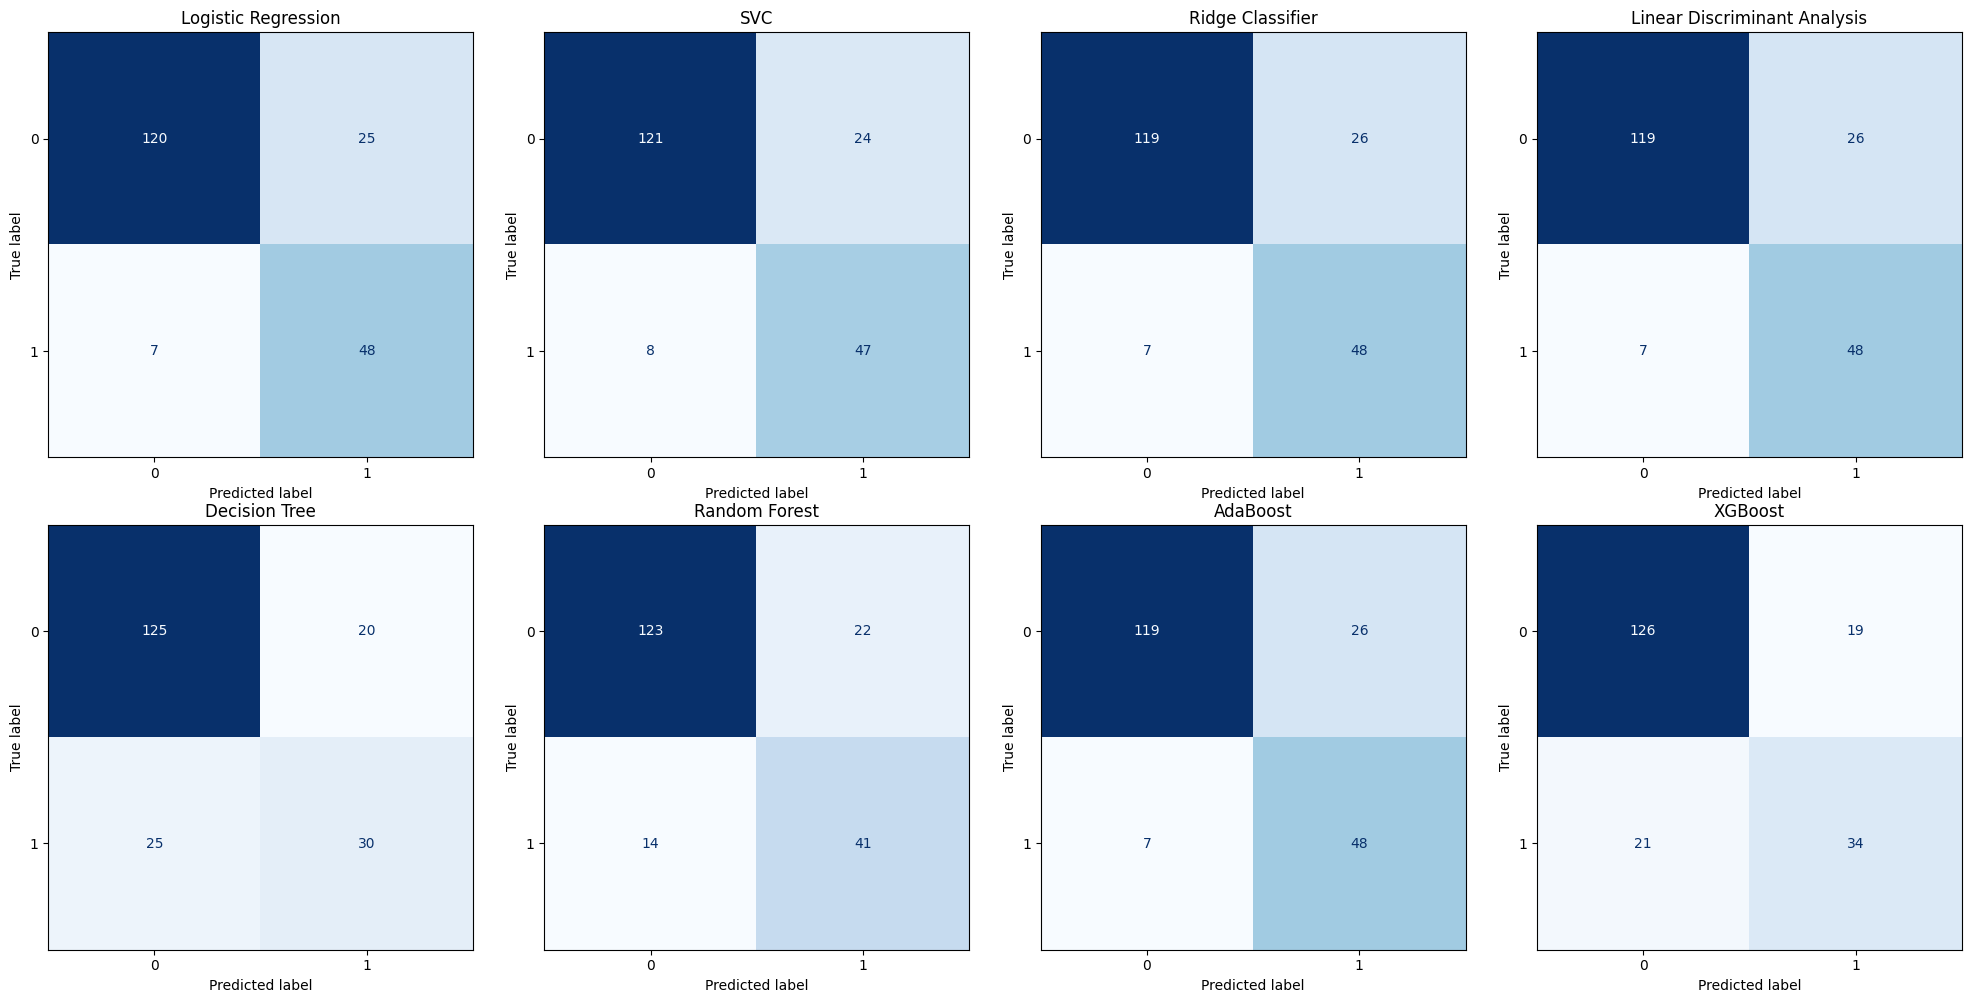



       Classification Report for Logistic Regression        
              precision  recall  f1-score  support
0                  0.94    0.83      0.88   145.00
1                  0.66    0.87      0.75    55.00
accuracy           0.84    0.84      0.84     0.84
macro avg          0.80    0.85      0.82   200.00
weighted avg       0.87    0.84      0.85   200.00


               Classification Report for SVC                
              precision  recall  f1-score  support
0                  0.94    0.83      0.88   145.00
1                  0.66    0.85      0.75    55.00
accuracy           0.84    0.84      0.84     0.84
macro avg          0.80    0.84      0.81   200.00
weighted avg       0.86    0.84      0.85   200.00


         Classification Report for Ridge Classifier         
              precision  recall  f1-score  support
0                  0.94    0.82      0.88   145.00
1                  0.65    0.87      0.74    55.00
accuracy           0.83    0.83      0.83     

In [12]:

# Models and their full names
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'SVC': SVC(random_state=42),
    'Ridge Classifier': RidgeClassifier(random_state=42),
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42)
}

results = []
confusion_matrices = {}
classification_reports = {}

for model_name, model in models.items():
    # Train the model once
    model.fit(X_train_ros, y_train_ros)

    # Make predictions once
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train_ros)

    # Calculate F1 scores
    test_f1 = f1_score(y_test, y_pred_test)
    train_f1 = f1_score(y_train_ros, y_pred_train)
    test_f1_weighted = f1_score(y_test, y_pred_test, average='weighted')
    train_f1_weighted = f1_score(y_train_ros, y_pred_train, average='weighted')

    # Calculate the difference in scores
    f1_diff = train_f1 - test_f1
    f1_weighted_diff = train_f1_weighted - test_f1_weighted

    results.append({
        'Model': model_name,
        'Train F1 (weighted)': train_f1_weighted,
        'Test F1 (weighted)': test_f1_weighted,
        'F1 (weighted) Difference': f1_weighted_diff,
        'Train F1 (pos. class)': train_f1,
        'Test F1 (pos. class)': test_f1,
        'F1 Difference (pos. class)': f1_diff
    })

    # Calculate and store confusion matrix
    cm = confusion_matrix(y_test, y_pred_test)
    confusion_matrices[model_name] = cm

    # Calculate and store classification report
    report = classification_report(y_test, y_pred_test, output_dict=True)
    classification_reports[model_name] = report

# Display F1 Score Results with Differences
df_results = pd.DataFrame(results)
print("F1 Scores and Differences:")
display(round(df_results, 3))
print("\n" + "=" * 60 + "\n")

# Display Confusion Matrices
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()
for i, (model_name, cm) in enumerate(confusion_matrices.items()):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
    axes[i].set_title(model_name)
    axes[i].grid(False)
for j in range(len(models), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()
print("\n" + "=" * 60 + "\n")

# Display Classification Reports
for model_name, report in classification_reports.items():
    print("=" * 60)
    print(f"{'Classification Report for ' + model_name:^60}")
    print("=" * 60)
    df_report = pd.DataFrame(report).transpose()
    print(df_report)
    print("\n")

### Smotetomek

F1 Scores and Differences:


,Model,Train F1 (weighted),Test F1 (weighted),F1 (weighted) Difference,Train F1 (pos. class),Test F1 (pos. class),F1 Difference (pos. class)
0,Logistic Regression,0.89,0.84,0.05,0.89,0.74,0.15
1,SVC,0.93,0.83,0.10,0.94,0.73,0.21
2,Ridge Classifier,0.89,0.84,0.05,0.89,0.74,0.15
3,Linear Discriminant Analysis,0.89,0.84,0.05,0.89,0.74,0.15
4,Decision Tree,1.00,0.79,0.21,1.00,0.62,0.38
5,Random Forest,1.00,0.81,0.19,1.00,0.66,0.34
6,AdaBoost,0.90,0.83,0.07,0.91,0.71,0.20
7,XGBoost,1.00,0.82,0.18,1.00,0.67,0.33


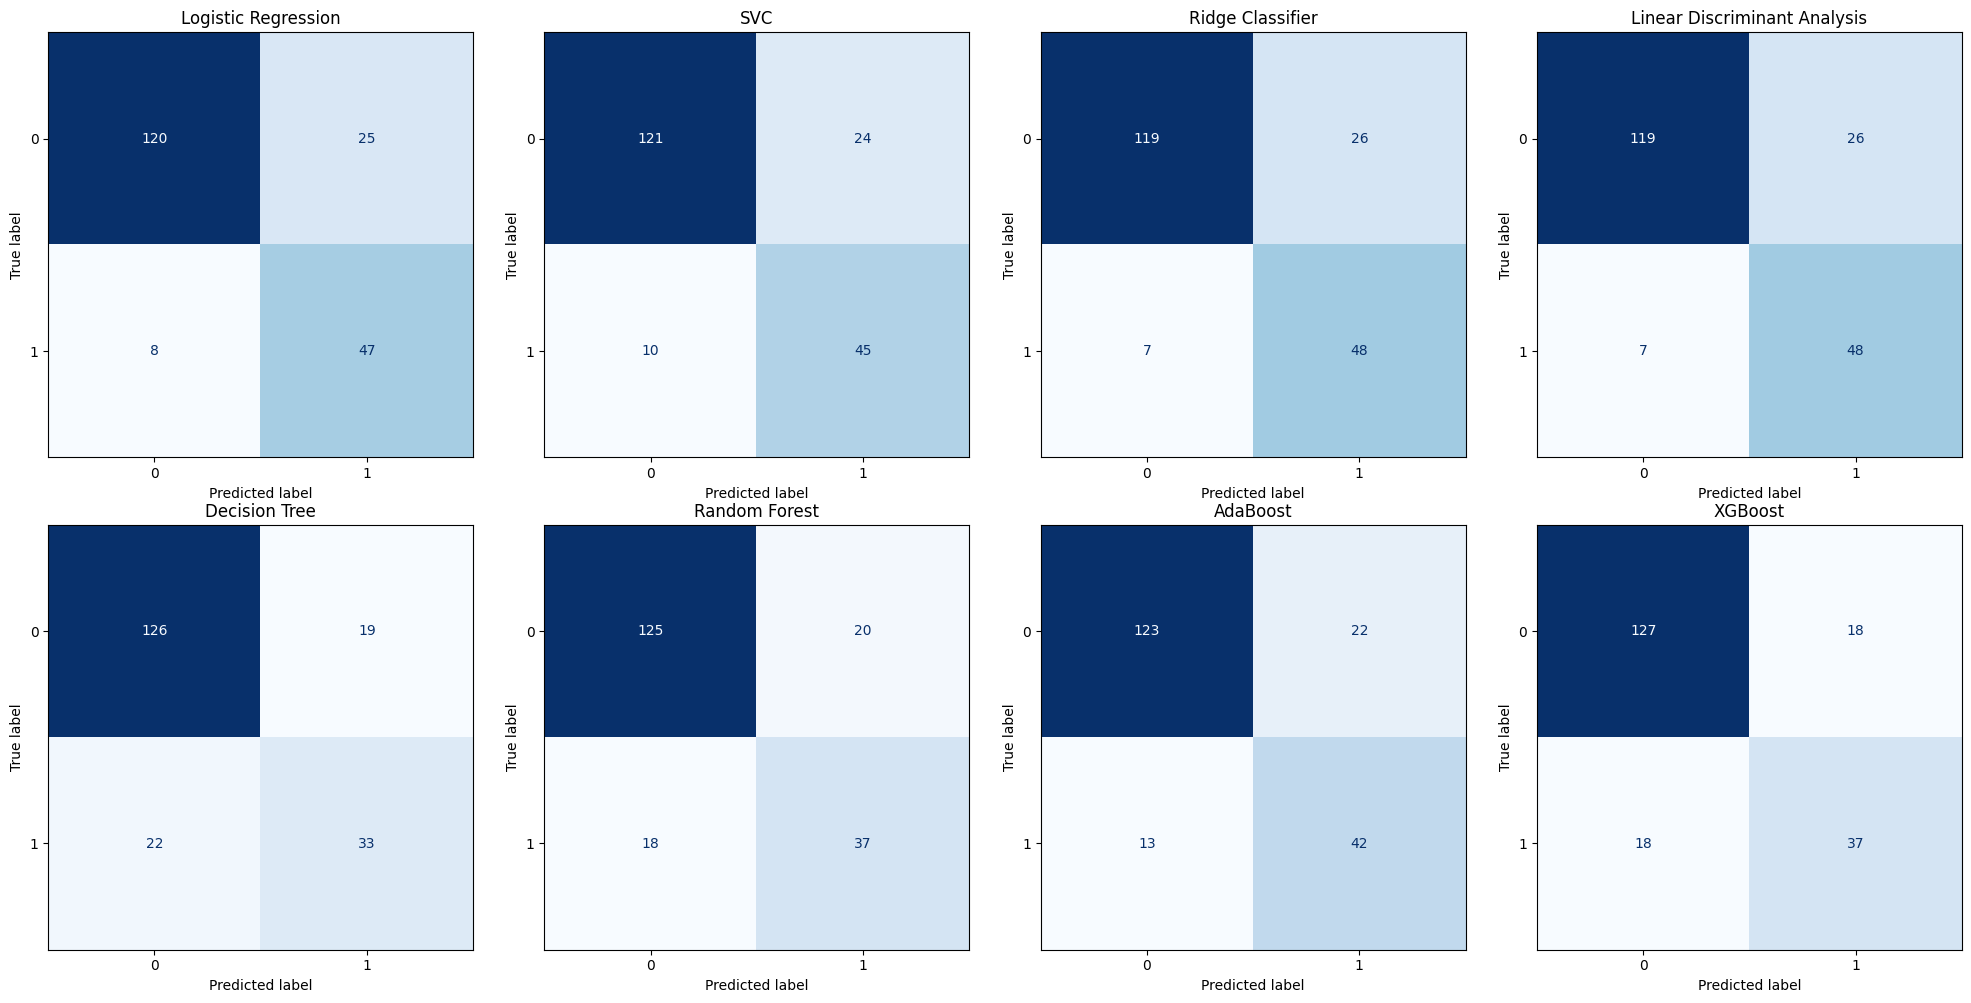



       Classification Report for Logistic Regression        
              precision  recall  f1-score  support
0                  0.94    0.83      0.88   145.00
1                  0.65    0.85      0.74    55.00
accuracy           0.83    0.83      0.83     0.83
macro avg          0.80    0.84      0.81   200.00
weighted avg       0.86    0.83      0.84   200.00


               Classification Report for SVC                
              precision  recall  f1-score  support
0                  0.92    0.83      0.88   145.00
1                  0.65    0.82      0.73    55.00
accuracy           0.83    0.83      0.83     0.83
macro avg          0.79    0.83      0.80   200.00
weighted avg       0.85    0.83      0.84   200.00


         Classification Report for Ridge Classifier         
              precision  recall  f1-score  support
0                  0.94    0.82      0.88   145.00
1                  0.65    0.87      0.74    55.00
accuracy           0.83    0.83      0.83     

In [13]:

# Models and their full names
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'SVC': SVC(random_state=42),
    'Ridge Classifier': RidgeClassifier(random_state=42),
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42)
}

results = []
confusion_matrices = {}
classification_reports = {}

for model_name, model in models.items():
    # Train the model once
    model.fit(X_train_smotetom, y_train_smotetom)

    # Make predictions once
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train_smotetom)

    # Calculate F1 scores
    test_f1 = f1_score(y_test, y_pred_test)
    train_f1 = f1_score(y_train_smotetom, y_pred_train)
    test_f1_weighted = f1_score(y_test, y_pred_test, average='weighted')
    train_f1_weighted = f1_score(y_train_smotetom, y_pred_train, average='weighted')

    # Calculate the difference in scores
    f1_diff = train_f1 - test_f1
    f1_weighted_diff = train_f1_weighted - test_f1_weighted

    results.append({
        'Model': model_name,
        'Train F1 (weighted)': train_f1_weighted,
        'Test F1 (weighted)': test_f1_weighted,
        'F1 (weighted) Difference': f1_weighted_diff,
        'Train F1 (pos. class)': train_f1,
        'Test F1 (pos. class)': test_f1,
        'F1 Difference (pos. class)': f1_diff
    })

    # Calculate and store confusion matrix
    cm = confusion_matrix(y_test, y_pred_test)
    confusion_matrices[model_name] = cm

    # Calculate and store classification report
    report = classification_report(y_test, y_pred_test, output_dict=True)
    classification_reports[model_name] = report

# Display F1 Score Results with Differences
df_results = pd.DataFrame(results)
print("F1 Scores and Differences:")
display(round(df_results, 3))
print("\n" + "=" * 60 + "\n")

# Display Confusion Matrices
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()
for i, (model_name, cm) in enumerate(confusion_matrices.items()):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
    axes[i].set_title(model_name)
    axes[i].grid(False)
for j in range(len(models), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()
print("\n" + "=" * 60 + "\n")

# Display Classification Reports
for model_name, report in classification_reports.items():
    print("=" * 60)
    print(f"{'Classification Report for ' + model_name:^60}")
    print("=" * 60)
    df_report = pd.DataFrame(report).transpose()
    print(df_report)
    print("\n")

## 8. Lazy predictor resampled sets

- Calibrated Classifier tested in notebook 2, as it is top in lazy classifier, however it had strong overfitting. 

In [14]:
# object
clf = LazyClassifier(random_state=42)
# fit
models = clf.fit(X_train_smotetom, X_test, y_train_smotetom, y_test)
# print
print('\n')
print('Smote Tomek')

#sort by F1 score
models[1].sort_values(by='F1 Score', ascending=False, inplace=True)
# print
models[1].head(10)

  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:01<00:00, 23.92it/s]

[LightGBM] [Info] Number of positive: 605, number of negative: 605
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 997
[LightGBM] [Info] Number of data points in the train set: 1210, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Smote Tomek


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
CalibratedClassifierCV,0.84,0.85,0.85,0.85,0.05
LogisticRegression,0.84,0.84,0.84,0.84,0.02
LinearSVC,0.83,0.85,0.85,0.84,0.02
LinearDiscriminantAnalysis,0.83,0.85,0.85,0.84,0.02
RidgeClassifierCV,0.83,0.85,0.85,0.84,0.02
RidgeClassifier,0.83,0.85,0.85,0.84,0.02
NuSVC,0.83,0.83,0.83,0.84,0.07
AdaBoostClassifier,0.82,0.81,0.81,0.83,0.13
SVC,0.82,0.80,0.80,0.83,0.06


## 9. Features importance on LDA with SmoteTomek

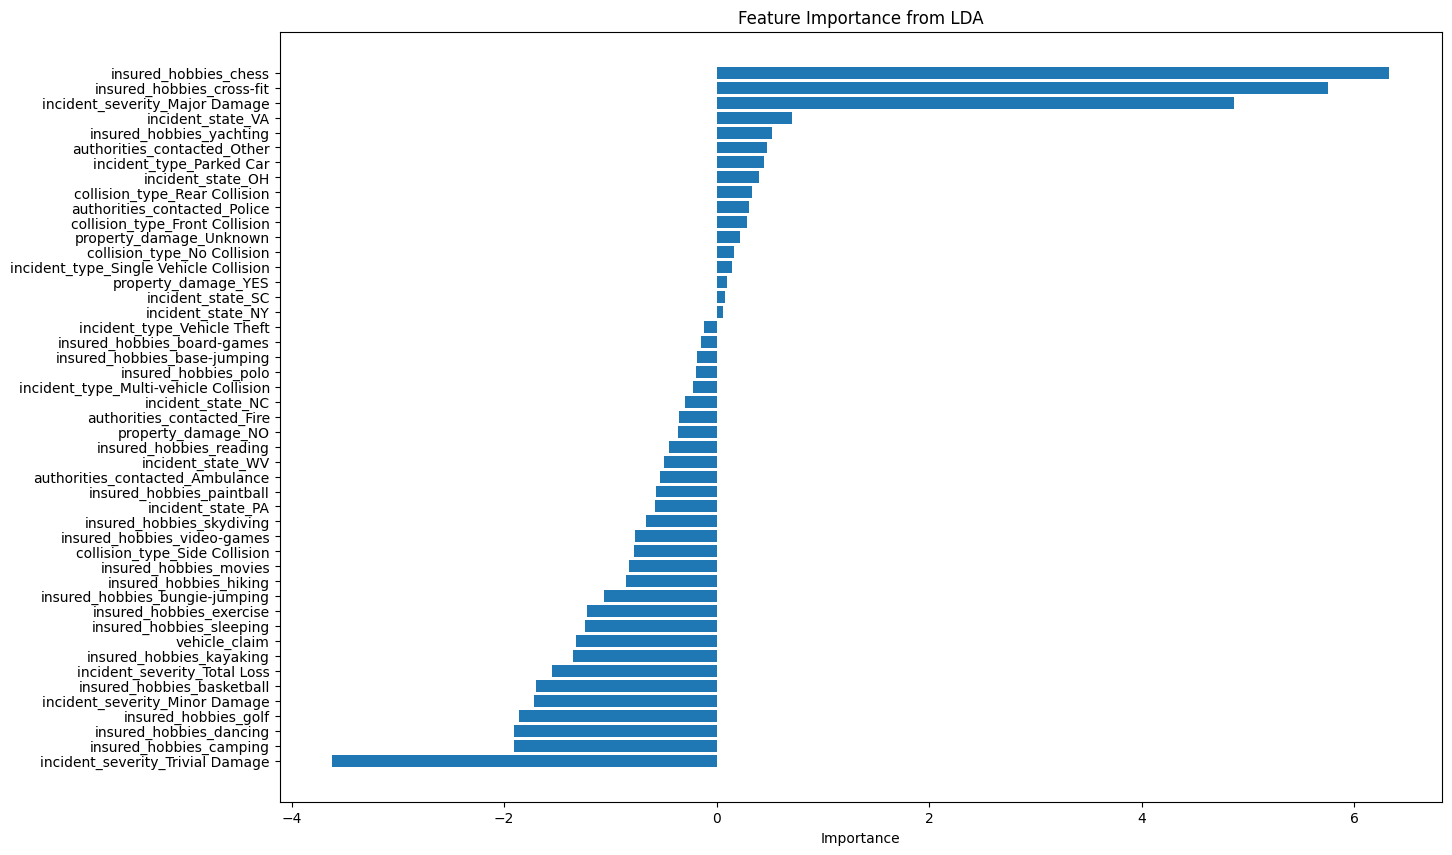

In [15]:
# lda features importance
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_smotetom, y_train_smotetom)
importance = lda.coef_[0]
# summarize feature importance
feature_names = X_train_smotetom.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
# plot feature importance
plt.figure(figsize=(15, 10))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance from LDA')
plt.gca().invert_yaxis()
plt.show()

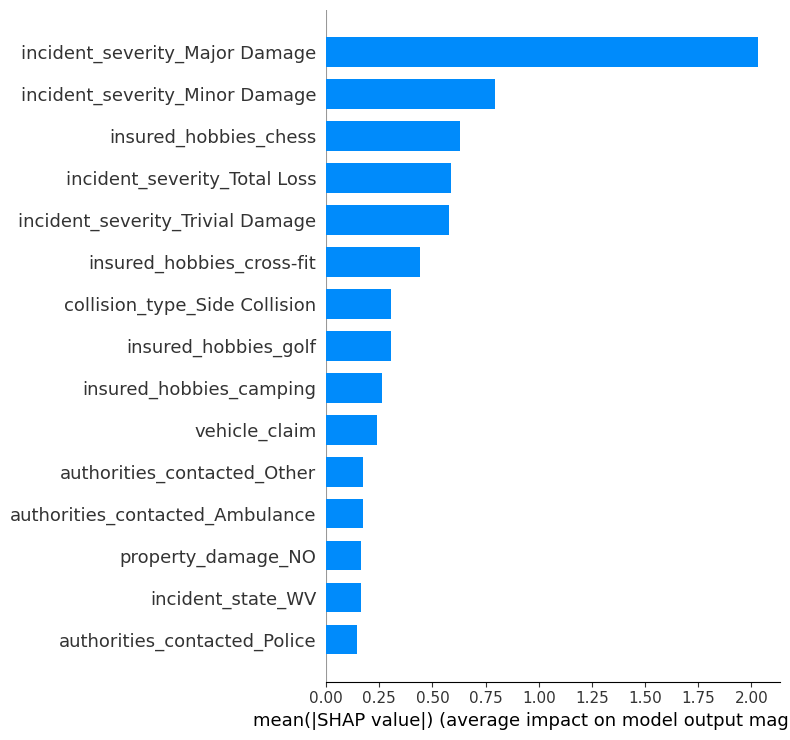

In [32]:
model_lda = LinearDiscriminantAnalysis()
model_lda.fit(X_train_smotetom, y_train_smotetom)

# 2. SHAP LinearExplainer einrichten
#    maskers.Independent sorgt dafür, dass die Feature-Kovarianzen berücksichtigt werden
explainer_lda = shap.LinearExplainer(
    model_lda, 
    shap.maskers.Independent(X_train), 
    feature_names=X_train.columns
)

# 3. SHAP-Werte für den Testdatensatz berechnen
shap_values_lda = explainer_lda.shap_values(X_test)

# 4. Zusammenfassungs-Bar-Plot der Top-15 Features
shap.summary_plot(
    shap_values_lda, 
    X_test, 
    plot_type="bar", 
    max_display=15
)

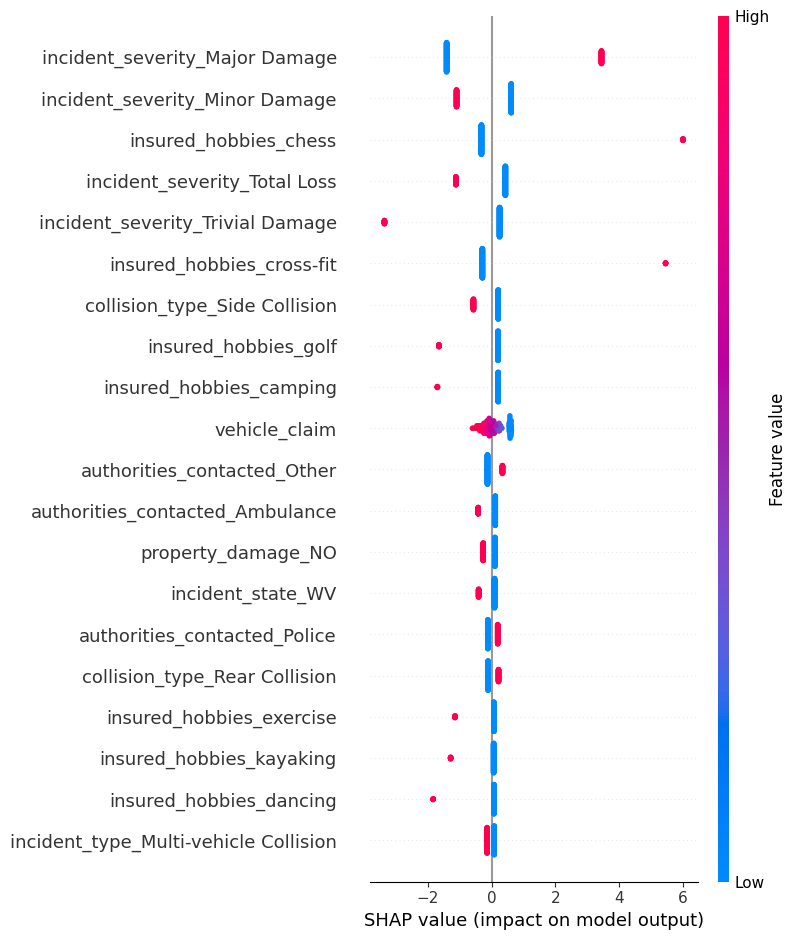

In [34]:
plt.figure(figsize=(58, 20))        
shap.summary_plot(shap_values_lda, X_test)

# Feature importance wit Logistic Regression

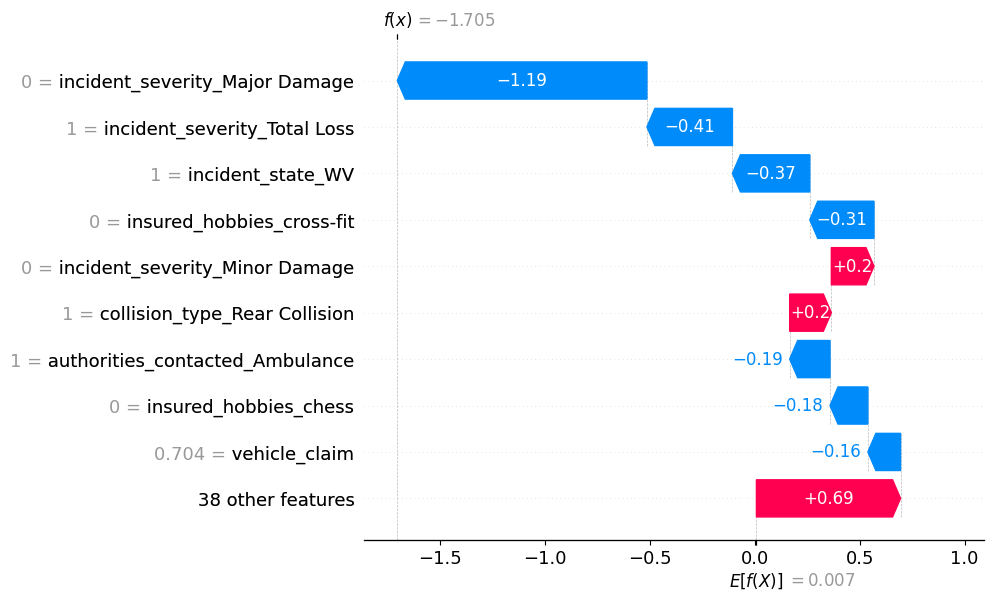

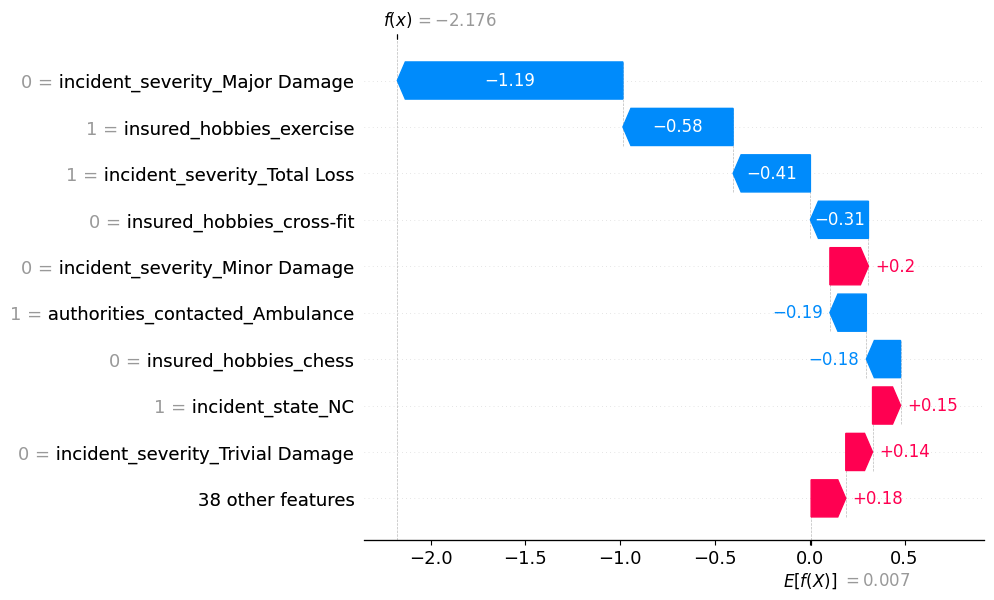

In [16]:
import shap

model = LogisticRegression(max_iter=1000)
model.fit(X_train_ros, y_train_ros)

# Create SHAP Explainer using the model and training data
explainer = shap.Explainer(model, X_train_ros)  # Automatically uses KernelExplainer for sklearn models
shap_values = explainer(X_test)  # This returns a proper Explanation object
shap.plots.waterfall(shap_values[0])

shap.plots.waterfall(shap_values[1])
plt.show()

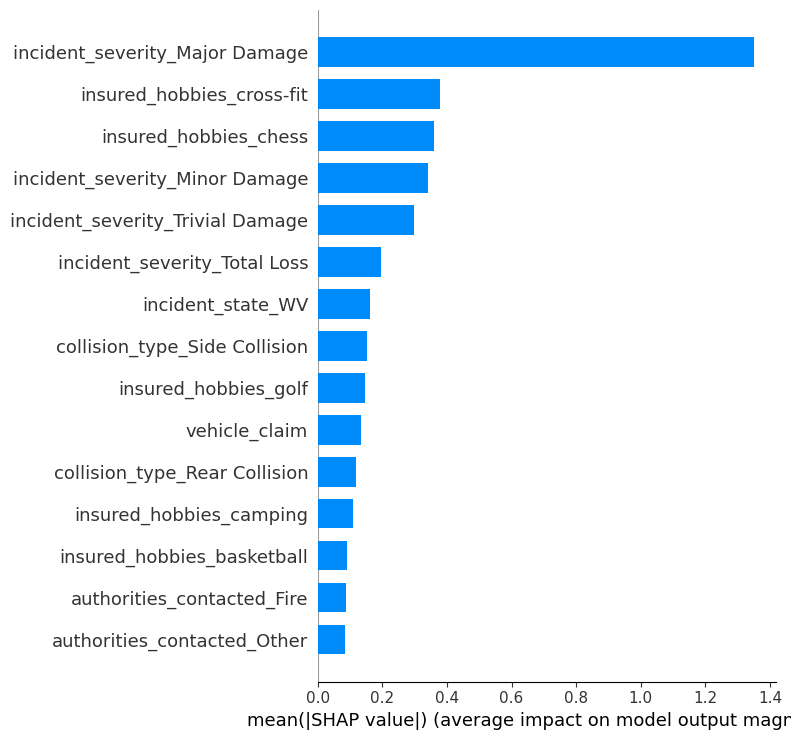

In [17]:
shap.summary_plot(
    shap_values.values,  # falls Explanation-Objekt, sonst shap_values direkt
    X_test,
    plot_type="bar",
    max_display=15      # zeigt die Top-15 Features
)

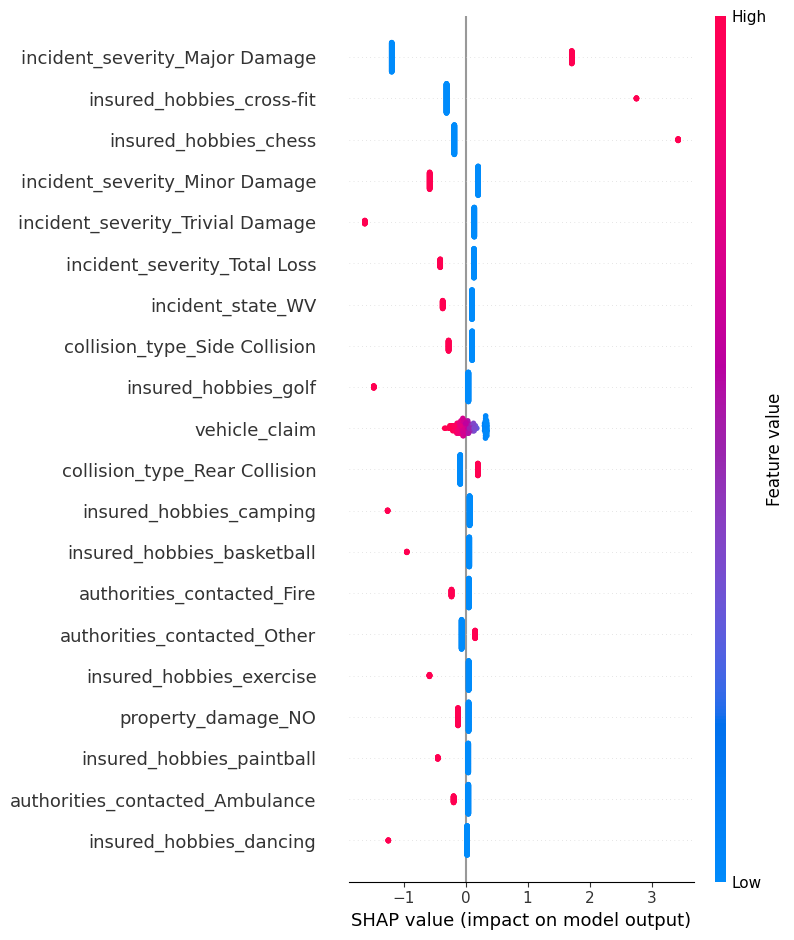

In [18]:
plt.figure(figsize=(58, 20))        
shap.summary_plot(shap_values, X_test)

In [19]:
# Nehme Sample 0
vals = shap_values[0].values  # oder: shap_values[0] wenn explainer(X_test) eine Explanation liefert
cols = X_test.columns

# Baue ein DataFrame zum Nachschlagen
df_shap = pd.DataFrame({
    "feature": cols,
    "shap_value": vals
})

# Sortiere nach absolutem Effekt
df_shap["abs_shap"] = df_shap["shap_value"].abs()
df_shap = df_shap.sort_values("abs_shap", ascending=False)

# Zeige die Top 10 Features
df_shap.head(10)

,feature,shap_value,abs_shap
40,incident_severity_Major Damage,-1.19,1.19
42,incident_severity_Total Loss,-0.41,0.41
39,incident_state_WV,-0.37,0.37
7,insured_hobbies_cross-fit,-0.31,0.31
41,incident_severity_Minor Damage,0.20,0.20
27,collision_type_Rear Collision,0.20,0.20
29,authorities_contacted_Ambulance,-0.19,0.19
6,insured_hobbies_chess,-0.18,0.18
0,vehicle_claim,-0.16,0.16
43,incident_severity_Trivial Damage,0.14,0.14


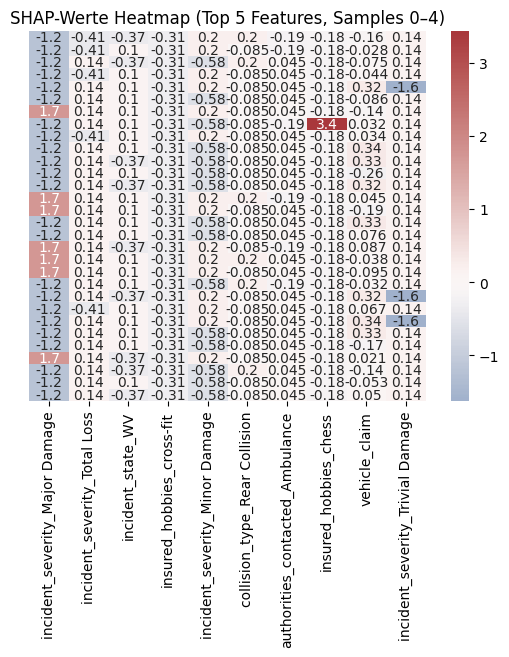

In [20]:
import seaborn as sns
# Top-5 Features und Top-5 Samples
top_feats = df_shap.sort_values("abs_shap", ascending=False).feature.iloc[:10]
vals = shap_values[:30].values[:, [X_test.columns.get_loc(f) for f in top_feats]]

sns.heatmap(vals, annot=True, yticklabels=[f"Instanz {i}" for i in range(0)],
            xticklabels=top_feats, cmap="vlag", center=0)
plt.title("SHAP-Werte Heatmap (Top 5 Features, Samples 0–4)")
plt.show()

Text(0.5, 1.0, 'Top 10 SHAP-Effekte für Sample 0')

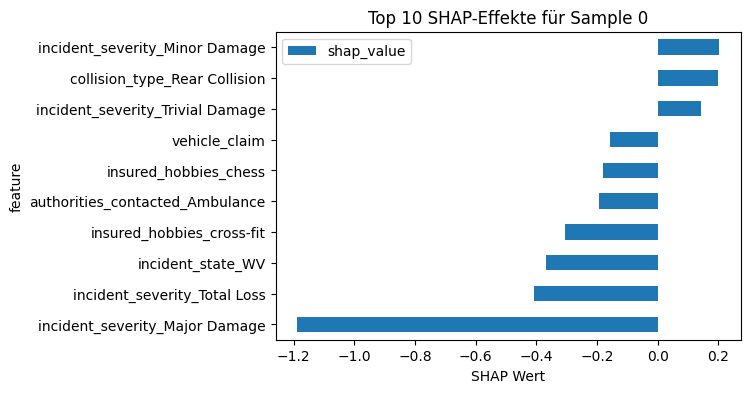

In [21]:
df_top = df_shap.head(10).sort_values("shap_value")
ax = df_top.plot.barh(x="feature", y="shap_value", figsize=(6,4))
ax.set_xlabel("SHAP Wert")
ax.set_title("Top 10 SHAP-Effekte für Sample 0")

Using 1216 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/200 [00:00<?, ?it/s]

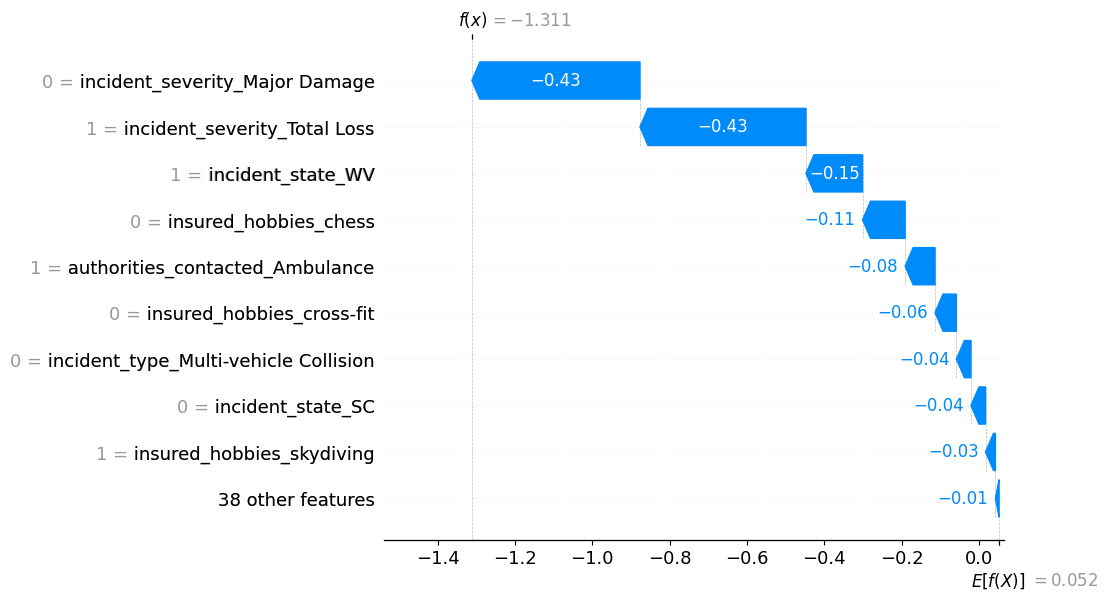

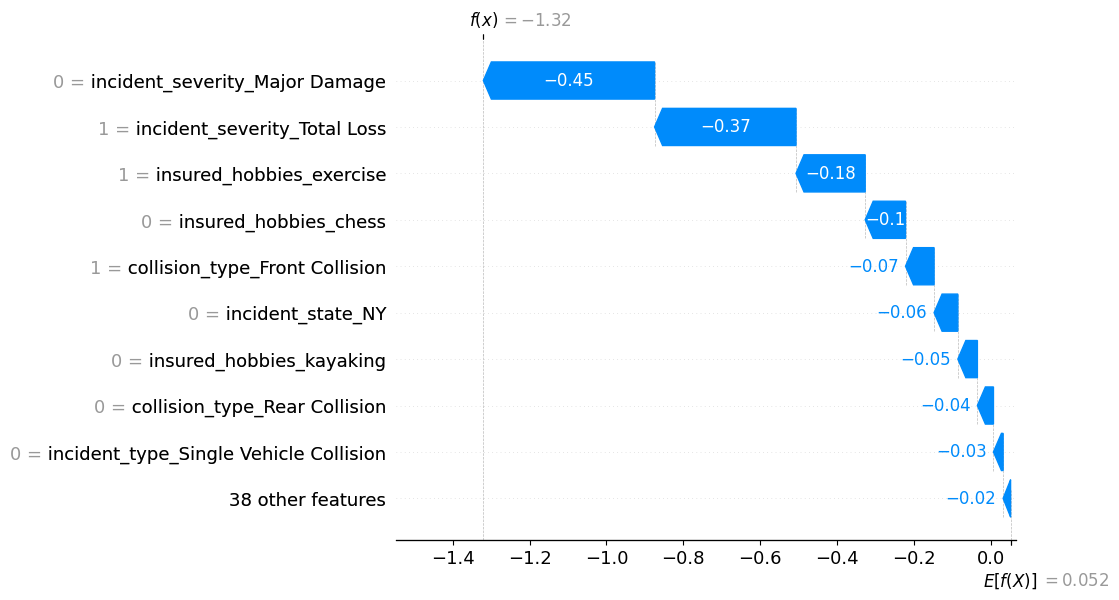

In [24]:
model_svc = SVC()
model_svc.fit(X_train_ros, y_train_ros)

# 2. Set up a KernelExplainer using the model's decision_function and 
#    a numpy background dataset (no torch import needed at runtime)
background = X_train_ros.values  # or X_train_ros.sample(100).values to speed up
explainer = shap.KernelExplainer(model_svc.decision_function, background)

# 3. Compute SHAP values for your test set (you can reduce nsamples for speed)
shap_values = explainer.shap_values(X_test.values, nsamples=100)

# 4. Wrap each sample's array into an Explanation and plot waterfalls
for idx in [0, 1]:
    expl = shap.Explanation(
        values=shap_values[idx],
        base_values=explainer.expected_value,
        data=X_test.values[idx],
        feature_names=X_test.columns
    )
    shap.plots.waterfall(expl)

plt.show()

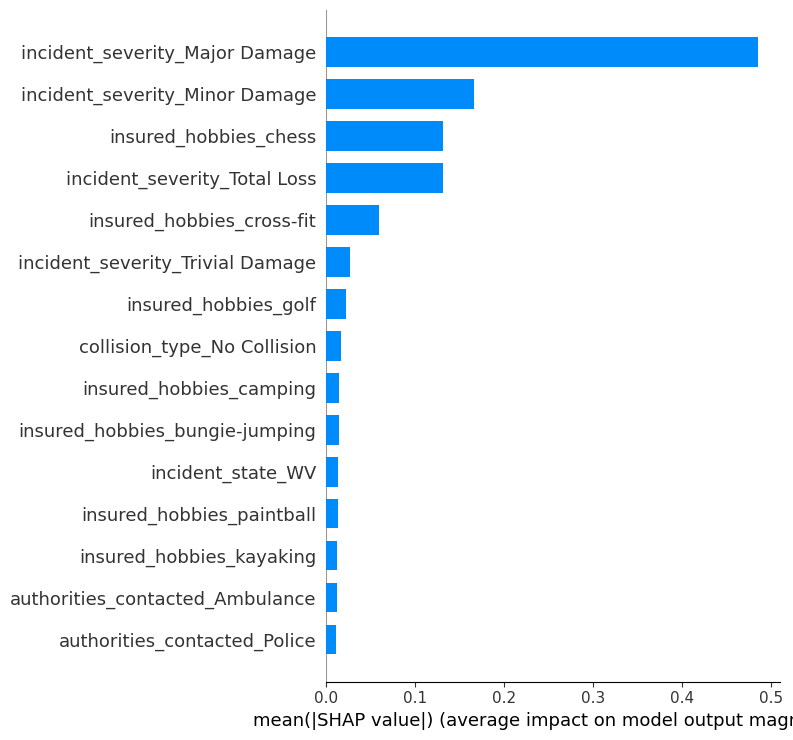

In [25]:
shap.summary_plot(
    shap_values if not hasattr(shap_values, "values") else shap_values.values,
    X_test,
    plot_type="bar",
    max_display=15
)
plt.show()

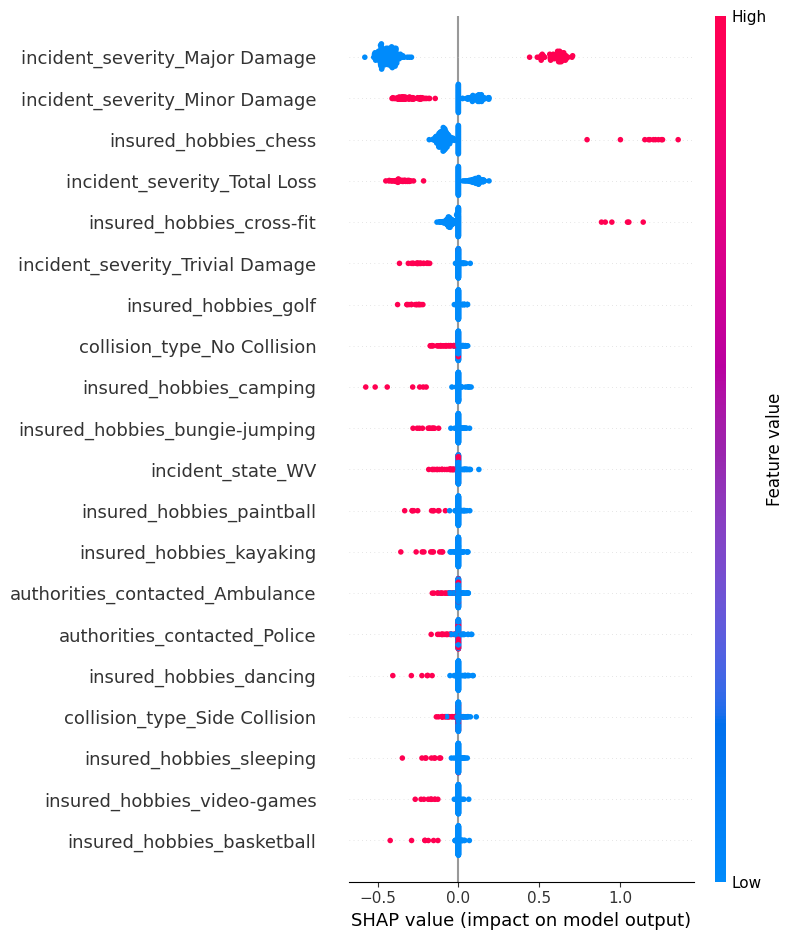

In [26]:
plt.figure(figsize=(58, 20))        
shap.summary_plot(shap_values, X_test)

PermutationExplainer explainer: 201it [00:18,  4.79it/s]                         


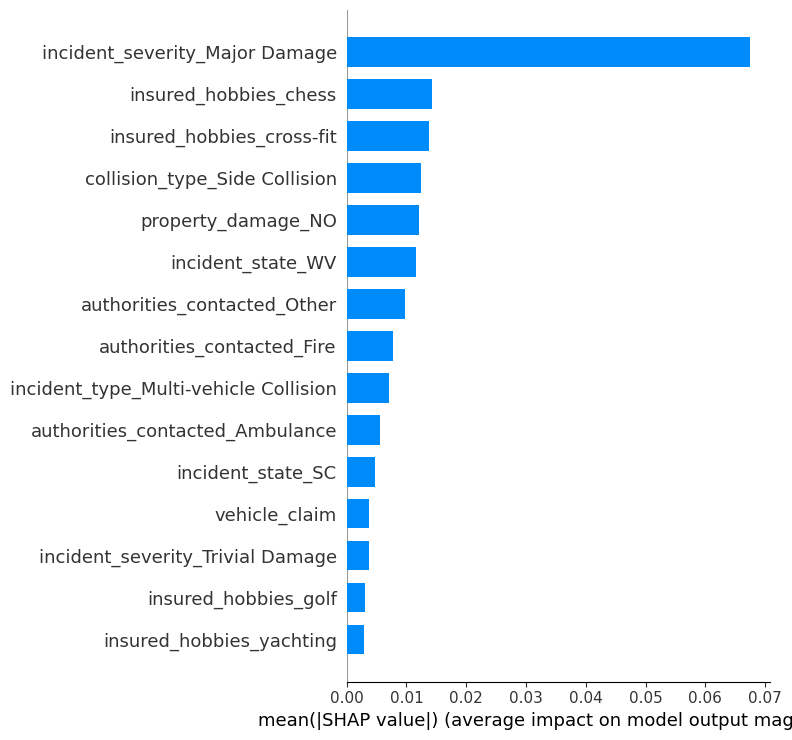

In [31]:
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier

# 1. Train AdaBoost
model_ab = AdaBoostClassifier()
model_ab.fit(X_train_smotetom, y_train_smotetom)

# 2. Baue eine Funktion, die für SHAP nur die Fraud-Wahrscheinlichkeit zurückgibt
f = lambda X: model_ab.predict_proba(X)[:, 1]

# 3. Erstelle den Explainer – shap wird hier automatisch KernelExplainer nutzen
explainer_ab = shap.Explainer(
    f, 
    X_train_ros, 
    feature_names=X_train_ros.columns
)

# 4. Berechne SHAP-Werte für den Test-Datensatz
shap_values_ab = explainer_ab(X_test)

# 5. Zusammenfassungs-Bar-Plot der Top-15 Merkmale
shap.summary_plot(
    shap_values_ab.values,  # oder shap_values_ab.values wenn es ein Explanation-Objekt ist
    X_test,
    plot_type="bar",
    max_display=15
)

plt.show()

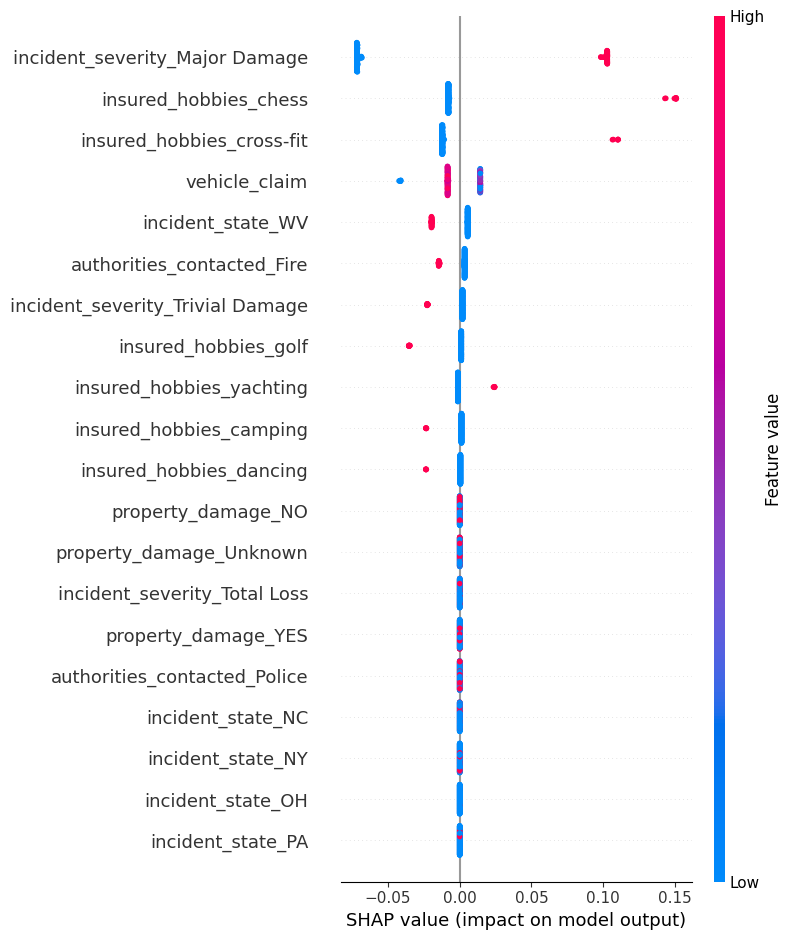

In [30]:
plt.figure(figsize=(58, 20))        
shap.summary_plot(shap_values_ab, X_test)

## 10. Gridsearches / Hyperparameter Optimization Smote Tomek
(RandomizedSearch for SVC, otherwise takes forever)

- best parameters for LDA, Ridge and AdaBoost give the same good scores to our models as above. 

#### Gridsearch for LDA, Ridge, AdaBoost

Grid Search for Linear Discriminant Analysis
Best Parameters: {'shrinkage': None, 'solver': 'svd'}
Best F1 Score: 0.8917

Grid Search for Ridge Classifier
Best Parameters: {'alpha': 0.01, 'solver': 'auto'}
Best F1 Score: 0.8917

Grid Search for AdaBoostClassifier
Best Parameters: {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 300}
Best F1 Score: 0.8969

Grid Search for LogisticRegression
Best Parameters: {'C': 1, 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'}
Best F1 Score: 0.8928


Evaluation of Best Models:
Linear Discriminant Analysis - Test set weighted F1: 0.8414, Train set weighted F1: 0.8874
Ridge Classifier - Test set weighted F1: 0.8414, Train set weighted F1: 0.8874
AdaBoostClassifier - Test set weighted F1: 0.8414, Train set weighted F1: 0.9031
LogisticRegression - Test set weighted F1: 0.8409, Train set weighted F1: 0.8908


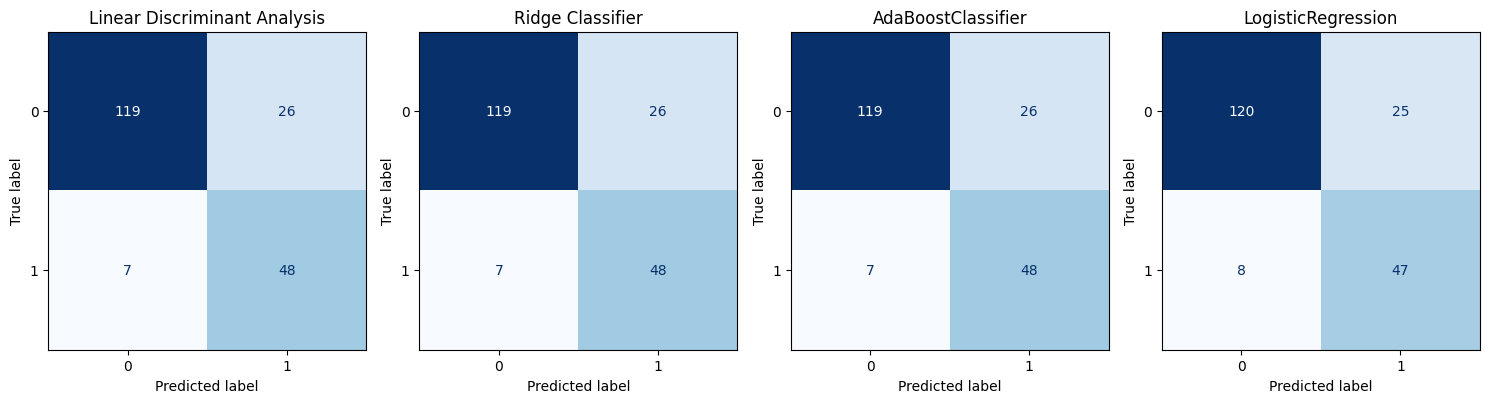

   Classification Report for Linear Discriminant Analysis   
              precision  recall  f1-score  support
0                  0.94    0.82      0.88   145.00
1                  0.65    0.87      0.74    55.00
accuracy           0.83    0.83      0.83     0.83
macro avg          0.80    0.85      0.81   200.00
weighted avg       0.86    0.83      0.84   200.00


         Classification Report for Ridge Classifier         
              precision  recall  f1-score  support
0                  0.94    0.82      0.88   145.00
1                  0.65    0.87      0.74    55.00
accuracy           0.83    0.83      0.83     0.83
macro avg          0.80    0.85      0.81   200.00
weighted avg       0.86    0.83      0.84   200.00


        Classification Report for AdaBoostClassifier        
              precision  recall  f1-score  support
0                  0.94    0.82      0.88   145.00
1                  0.65    0.87      0.74    55.00
accuracy           0.83    0.83      0.83     0.

In [ ]:
# Define the parameter grid for each model
param_grid = {
    'Linear Discriminant Analysis': {
        'solver': ['svd', 'lsqr', 'eigen'],
        'shrinkage': [None, 'auto', 0.1, 0.5, 0.9]
    },
    'Ridge Classifier': {
        'alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
        'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
    },
    'AdaBoostClassifier': {
        'n_estimators': [25, 50, 100, 200, 300],
        'learning_rate': [0.001, 0.01, 0.1, 1.0, 10.0],
        'algorithm': ['SAMME', 'SAMME.R']
    },
    'LogisticRegression': {
        'penalty': ['l1', 'l2', 'elasticnet', 'none'],  
        'C': [0.01, 0.1, 1, 10, 100],                   
        'solver': ['liblinear', 'saga'],              
        'l1_ratio': [0, 0.5, 1]   
    }
}

# Initialize the models
models = {
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
    'Ridge Classifier': RidgeClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'LogisticRegression':LogisticRegression()
}

# Initialize a dictionary to store the best models and their predictions
best_models = {}
test_predictions = {}
train_predictions = {}
grid_search_results = {}

# Perform Grid Search for each model
for model_name, model in models.items():
    print(f"Grid Search for {model_name}")
    grid_search = GridSearchCV(model, param_grid[model_name], cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train_smotetom, y_train_smotetom)
    best_models[model_name] = grid_search.best_estimator_
    test_predictions[model_name] = grid_search.best_estimator_.predict(X_test)
    train_predictions[model_name] = grid_search.best_estimator_.predict(X_train_smotetom)
    grid_search_results[model_name] = {
        'best_params': grid_search.best_params_,
        'best_f1_score': grid_search.best_score_
    }
    print(f"Best Parameters: {grid_search_results[model_name]['best_params']}")
    print(f"Best F1 Score: {grid_search_results[model_name]['best_f1_score']:.4f}\n")

# Evaluate the best models on the test set
print("\nEvaluation of Best Models:")
for model_name in best_models:
    test_f1 = f1_score(y_test, test_predictions[model_name], average='weighted')
    train_f1 = f1_score(y_train_smotetom, train_predictions[model_name], average= 'weighted')
    print(f"{model_name} - Test set weighted F1: {test_f1:.4f}, Train set weighted F1: {train_f1:.4f}")

# Confusion Matrices for the best models
fig, axes = plt.subplots(1, len(best_models), figsize=(15, 5)) # Adjusted subplots dynamically
if len(best_models) == 1:
    axes = [axes] # Make sure axes is iterable even for a single model
for i, model_name in enumerate(best_models):
    cm = confusion_matrix(y_test, test_predictions[model_name])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_models[model_name].classes_)
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
    axes[i].set_title(model_name)
    axes[i].grid(False)
plt.tight_layout()
plt.show()

# Classification Reports for the best models
for model_name in best_models:
    report = classification_report(y_test, test_predictions[model_name], output_dict=True)
    print("=" * 60)
    print(f"{'Classification Report for ' + model_name:^60}")
    print("=" * 60)
    df_report = pd.DataFrame(report).transpose()
    print(df_report)
    print("\n")

# Final Model Evaluation (you can choose based on grid_search_results)
# Example:
best_model_name = max(grid_search_results, key=lambda k: grid_search_results[k]['best_f1_score'])
print(f"\nBest model based on cross-validation F1 score: {best_model_name}")
print(f"Best parameters: {grid_search_results[best_model_name]['best_params']}")

Grid Search for Linear Discriminant Analysis
Best Parameters: {'shrinkage': None, 'solver': 'svd'}
Best F1 Score: 0.8708

Grid Search for Ridge Classifier
Best Parameters: {'alpha': 0.01, 'solver': 'auto'}
Best F1 Score: 0.8708

Grid Search for AdaBoostClassifier
Best Parameters: {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 300}
Best F1 Score: 0.8695

Grid Search for SVC
Best Parameters: {'C': 10, 'degree': 2, 'gamma': 1, 'kernel': 'rbf'}
Best F1 Score: 0.9706

Grid Search for LogisticRegression
Best Parameters: {'C': 0.1, 'l1_ratio': 0, 'penalty': 'l1', 'solver': 'liblinear'}
Best F1 Score: 0.8708


Evaluation of Best Models:
Linear Discriminant Analysis - Test set weighted F1: 0.8414, Train set weighted F1: 0.8684
Ridge Classifier - Test set weighted F1: 0.8414, Train set weighted F1: 0.8684
AdaBoostClassifier - Test set weighted F1: 0.8414, Train set weighted F1: 0.8684
SVC - Test set weighted F1: 0.6323, Train set weighted F1: 1.0000
LogisticRegression - Test set we

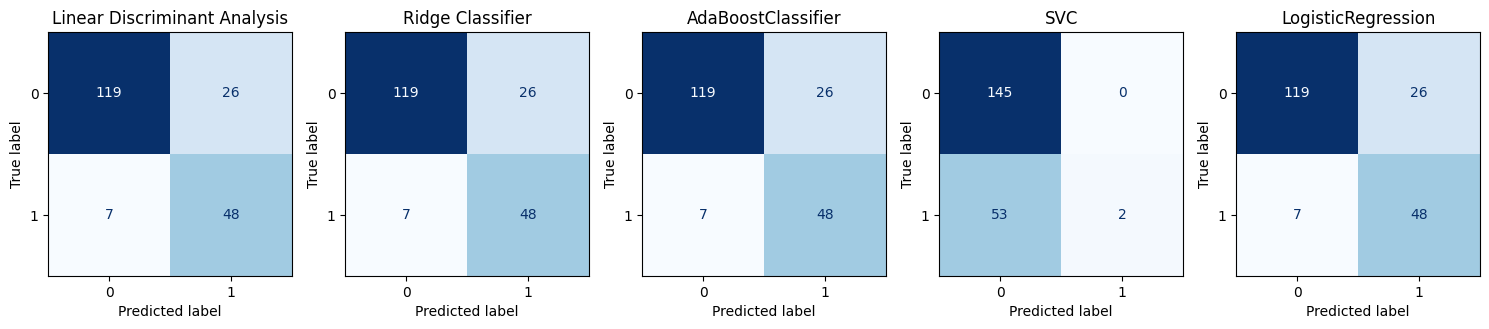

   Classification Report for Linear Discriminant Analysis   
              precision  recall  f1-score  support
0                  0.94    0.82      0.88   145.00
1                  0.65    0.87      0.74    55.00
accuracy           0.83    0.83      0.83     0.83
macro avg          0.80    0.85      0.81   200.00
weighted avg       0.86    0.83      0.84   200.00


         Classification Report for Ridge Classifier         
              precision  recall  f1-score  support
0                  0.94    0.82      0.88   145.00
1                  0.65    0.87      0.74    55.00
accuracy           0.83    0.83      0.83     0.83
macro avg          0.80    0.85      0.81   200.00
weighted avg       0.86    0.83      0.84   200.00


        Classification Report for AdaBoostClassifier        
              precision  recall  f1-score  support
0                  0.94    0.82      0.88   145.00
1                  0.65    0.87      0.74    55.00
accuracy           0.83    0.83      0.83     0.

In [ ]:
# Define the parameter grid for each model
param_grid = {
    'Linear Discriminant Analysis': {
        'solver': ['svd', 'lsqr', 'eigen'],
        'shrinkage': [None, 'auto', 0.1, 0.5, 0.9]
    },
    'Ridge Classifier': {
        'alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
        'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
    },
    'AdaBoostClassifier': {
        'n_estimators': [25, 50, 100, 200, 300],
        'learning_rate': [0.001, 0.01, 0.1, 1.0, 10.0],
        'algorithm': ['SAMME', 'SAMME.R']
    },
    'SVC': {
        'C': [0.1, 1, 10, 100],               # Regularisierung
        'kernel': ['linear', 'rbf', 'poly'], # Kerneltyp
        'gamma': ['scale', 'auto', 0.01, 0.1, 1],  # Nur für 'rbf' und 'poly' relevant
        'degree': [2, 3, 4]  
    },
    'LogisticRegression': {
        'penalty': ['l1', 'l2', 'elasticnet', 'none'],  
        'C': [0.01, 0.1, 1, 10, 100],                   
        'solver': ['liblinear', 'saga'],              
        'l1_ratio': [0, 0.5, 1]   
    }
}

# Initialize the models
models = {
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
    'Ridge Classifier': RidgeClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'SVC':SVC(),
    'LogisticRegression':LogisticRegression()
}

# Initialize a dictionary to store the best models and their predictions
best_models = {}
test_predictions = {}
train_predictions = {}
grid_search_results = {}

# Perform Grid Search for each model
for model_name, model in models.items():
    print(f"Grid Search for {model_name}")
    grid_search = GridSearchCV(model, param_grid[model_name], cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train_ros, y_train_ros)
    best_models[model_name] = grid_search.best_estimator_
    test_predictions[model_name] = grid_search.best_estimator_.predict(X_test)
    train_predictions[model_name] = grid_search.best_estimator_.predict(X_train_ros)
    grid_search_results[model_name] = {
        'best_params': grid_search.best_params_,
        'best_f1_score': grid_search.best_score_
    }
    print(f"Best Parameters: {grid_search_results[model_name]['best_params']}")
    print(f"Best F1 Score: {grid_search_results[model_name]['best_f1_score']:.4f}\n")

# Evaluate the best models on the test set
print("\nEvaluation of Best Models:")
for model_name in best_models:
    test_f1 = f1_score(y_test, test_predictions[model_name], average='weighted')
    train_f1 = f1_score(y_train_ros, train_predictions[model_name], average= 'weighted')
    print(f"{model_name} - Test set weighted F1: {test_f1:.4f}, Train set weighted F1: {train_f1:.4f}")

# Confusion Matrices for the best models
fig, axes = plt.subplots(1, len(best_models), figsize=(15, 5)) # Adjusted subplots dynamically
if len(best_models) == 1:
    axes = [axes] # Make sure axes is iterable even for a single model
for i, model_name in enumerate(best_models):
    cm = confusion_matrix(y_test, test_predictions[model_name])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_models[model_name].classes_)
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
    axes[i].set_title(model_name)
    axes[i].grid(False)
plt.tight_layout()
plt.show()

# Classification Reports for the best models
for model_name in best_models:
    report = classification_report(y_test, test_predictions[model_name], output_dict=True)
    print("=" * 60)
    print(f"{'Classification Report for ' + model_name:^60}")
    print("=" * 60)
    df_report = pd.DataFrame(report).transpose()
    print(df_report)
    print("\n")

# Final Model Evaluation (you can choose based on grid_search_results)
# Example:
best_model_name = max(grid_search_results, key=lambda k: grid_search_results[k]['best_f1_score'])
print(f"\nBest model based on cross-validation F1 score: {best_model_name}")
print(f"Best parameters: {grid_search_results[best_model_name]['best_params']}")

Grid Search for Linear Discriminant Analysis
Best Parameters: {'shrinkage': 0.1, 'solver': 'lsqr'}
Best F1 Score: 0.7154

Grid Search for Ridge Classifier
Best Parameters: {'alpha': 0.01, 'solver': 'auto'}
Best F1 Score: 0.7017

Grid Search for AdaBoostClassifier
Best Parameters: {'algorithm': 'SAMME', 'learning_rate': 0.001, 'n_estimators': 25}
Best F1 Score: 0.6439

Grid Search for SVC
Best Parameters: {'C': 100, 'degree': 2, 'gamma': 0.01, 'kernel': 'rbf'}
Best F1 Score: 0.7312

Grid Search for LogisticRegression
Best Parameters: {'C': 1, 'l1_ratio': 0, 'penalty': 'l1', 'solver': 'liblinear'}
Best F1 Score: 0.6968


Evaluation of Best Models:
Linear Discriminant Analysis - Test set weighted F1: 0.8398, Train set weighted F1: 0.8657
Ridge Classifier - Test set weighted F1: 0.8490, Train set weighted F1: 0.8774
AdaBoostClassifier - Test set weighted F1: 0.7834, Train set weighted F1: 0.8221
SVC - Test set weighted F1: 0.8340, Train set weighted F1: 0.8954
LogisticRegression - Test set

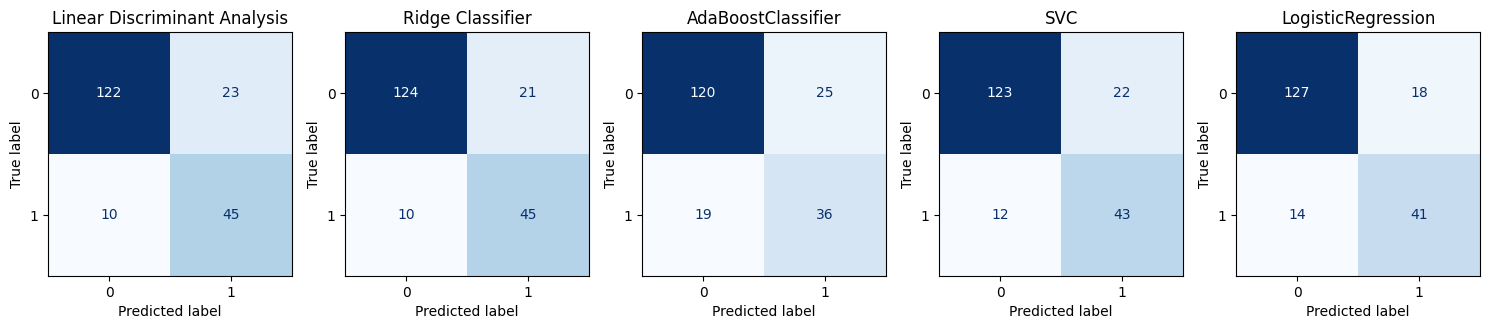

   Classification Report for Linear Discriminant Analysis   
              precision  recall  f1-score  support
0                  0.92    0.84      0.88   145.00
1                  0.66    0.82      0.73    55.00
accuracy           0.83    0.83      0.83     0.83
macro avg          0.79    0.83      0.81   200.00
weighted avg       0.85    0.83      0.84   200.00


         Classification Report for Ridge Classifier         
              precision  recall  f1-score  support
0                  0.93    0.86      0.89   145.00
1                  0.68    0.82      0.74    55.00
accuracy           0.84    0.84      0.84     0.84
macro avg          0.80    0.84      0.82   200.00
weighted avg       0.86    0.84      0.85   200.00


        Classification Report for AdaBoostClassifier        
              precision  recall  f1-score  support
0                  0.86    0.83      0.85   145.00
1                  0.59    0.65      0.62    55.00
accuracy           0.78    0.78      0.78     0.

In [ ]:
# Define the parameter grid for each model
param_grid = {
    'Linear Discriminant Analysis': {
        'solver': ['svd', 'lsqr', 'eigen'],
        'shrinkage': [None, 'auto', 0.1, 0.5, 0.9]
    },
    'Ridge Classifier': {
        'alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
        'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
    },
    'AdaBoostClassifier': {
        'n_estimators': [25, 50, 100, 200, 300],
        'learning_rate': [0.001, 0.01, 0.1, 1.0, 10.0],
        'algorithm': ['SAMME', 'SAMME.R']
    },
    'SVC': {
        'C': [0.1, 1, 10, 100],               # Regularisierung
        'kernel': ['linear', 'rbf', 'poly'], # Kerneltyp
        'gamma': ['scale', 'auto', 0.01, 0.1, 1],  # Nur für 'rbf' und 'poly' relevant
        'degree': [2, 3, 4]  
    },
    'LogisticRegression': {
        'penalty': ['l1', 'l2', 'elasticnet', 'none'],  
        'C': [0.01, 0.1, 1, 10, 100],                   
        'solver': ['liblinear', 'saga'],              
        'l1_ratio': [0, 0.5, 1]   
    }
}

# Initialize the models
models = {
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
    'Ridge Classifier': RidgeClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'SVC':SVC(),
    'LogisticRegression':LogisticRegression()
}

# Initialize a dictionary to store the best models and their predictions
best_models = {}
test_predictions = {}
train_predictions = {}
grid_search_results = {}

# Perform Grid Search for each model
for model_name, model in models.items():
    print(f"Grid Search for {model_name}")
    grid_search = GridSearchCV(model, param_grid[model_name], cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_
    test_predictions[model_name] = grid_search.best_estimator_.predict(X_test)
    train_predictions[model_name] = grid_search.best_estimator_.predict(X_train)
    grid_search_results[model_name] = {
        'best_params': grid_search.best_params_,
        'best_f1_score': grid_search.best_score_
    }
    print(f"Best Parameters: {grid_search_results[model_name]['best_params']}")
    print(f"Best F1 Score: {grid_search_results[model_name]['best_f1_score']:.4f}\n")

# Evaluate the best models on the test set
print("\nEvaluation of Best Models:")
for model_name in best_models:
    test_f1 = f1_score(y_test, test_predictions[model_name], average='weighted')
    train_f1 = f1_score(y_train, train_predictions[model_name], average= 'weighted')
    print(f"{model_name} - Test set weighted F1: {test_f1:.4f}, Train set weighted F1: {train_f1:.4f}")

# Confusion Matrices for the best models
fig, axes = plt.subplots(1, len(best_models), figsize=(15, 5)) # Adjusted subplots dynamically
if len(best_models) == 1:
    axes = [axes] # Make sure axes is iterable even for a single model
for i, model_name in enumerate(best_models):
    cm = confusion_matrix(y_test, test_predictions[model_name])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_models[model_name].classes_)
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
    axes[i].set_title(model_name)
    axes[i].grid(False)
plt.tight_layout()
plt.show()

# Classification Reports for the best models
for model_name in best_models:
    report = classification_report(y_test, test_predictions[model_name], output_dict=True)
    print("=" * 60)
    print(f"{'Classification Report for ' + model_name:^60}")
    print("=" * 60)
    df_report = pd.DataFrame(report).transpose()
    print(df_report)
    print("\n")

# Final Model Evaluation (you can choose based on grid_search_results)
# Example:
best_model_name = max(grid_search_results, key=lambda k: grid_search_results[k]['best_f1_score'])
print(f"\nBest model based on cross-validation F1 score: {best_model_name}")
print(f"Best parameters: {grid_search_results[best_model_name]['best_params']}")

# 11. Stratified K-fold Cross Validation

- review overall model performance
- review consistency of model performance -- the more stable, the better
- compare between models


Average F1 Scores from Stratified K-Fold Cross-Validation (Validation Folds) with SMOTETomek
Average Validation F1 Score for Linear Discriminant Analysis: 0.8867
Average Validation F1 Score for Ridge Classifier: 0.8867
Average Validation F1 Score for AdaBoostClassifier: 0.8974
Average Validation F1 Score for Logistic Regression: 0.8858


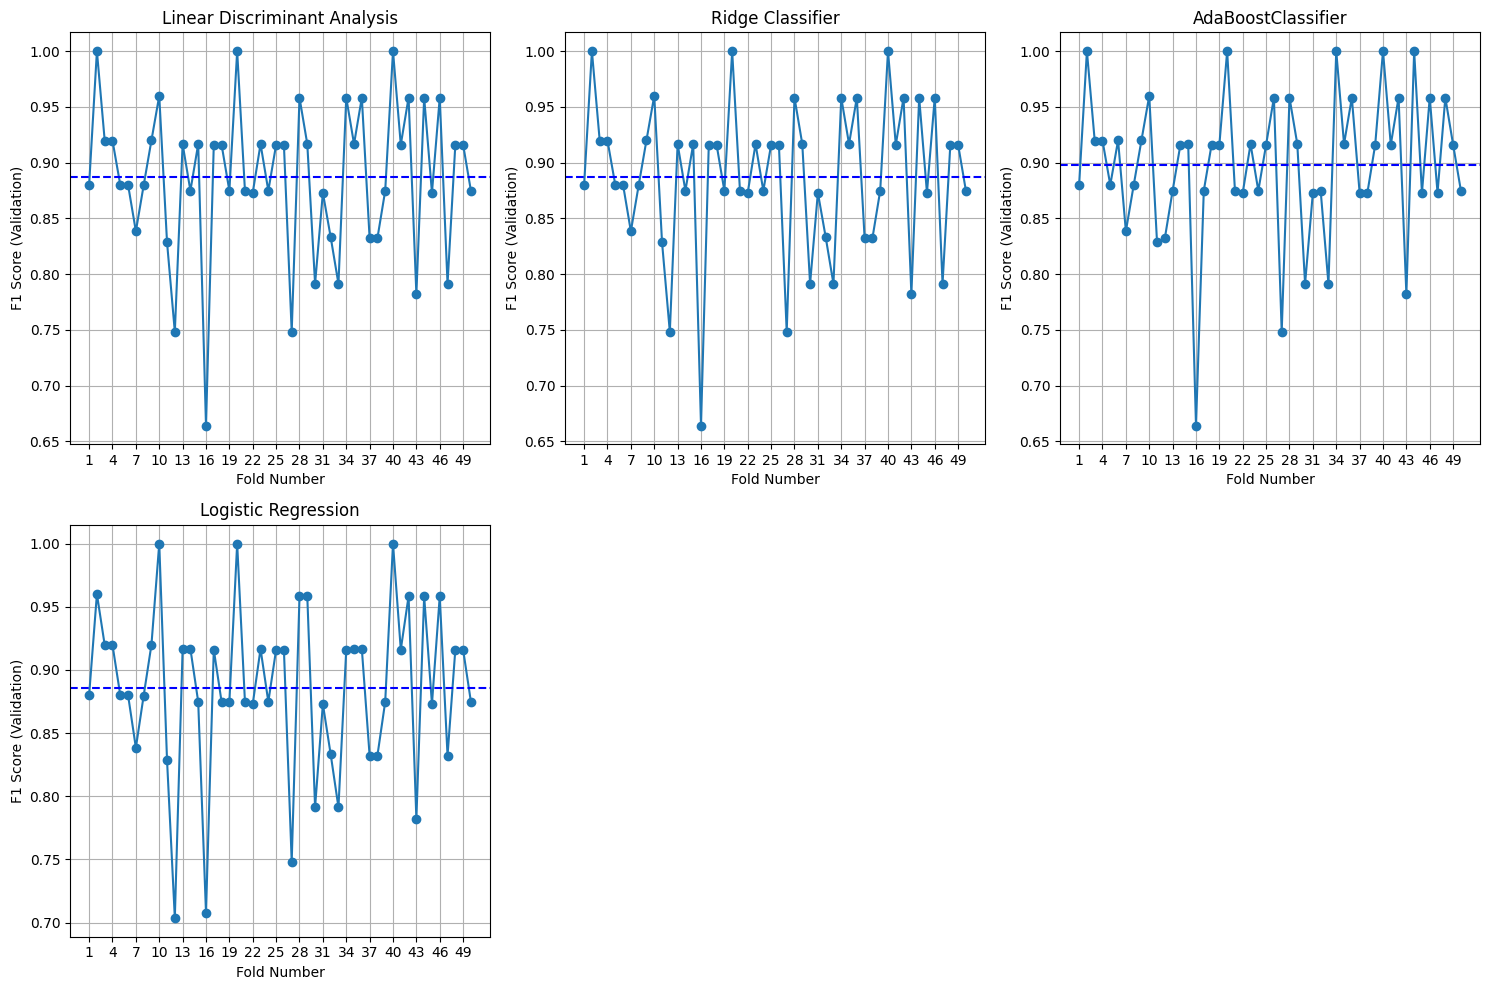


Best Model (based on average validation F1 with SMOTETomek): AdaBoostClassifier
Test F1 Score (on original unseen data): 0.7442
Variance of F1 Scores for each model:
Linear Discriminant Analysis: 0.0046
Ridge Classifier: 0.0046
AdaBoostClassifier: 0.0043
Logistic Regression: 0.0043


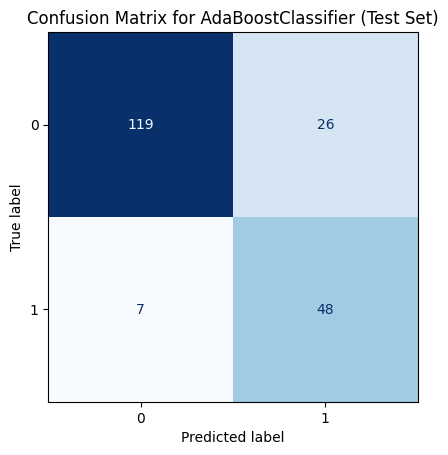

In [ ]:
print('Average F1 Scores from Stratified K-Fold Cross-Validation (Validation Folds) with SMOTETomek')
models = {
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis(shrinkage = None, solver = 'svd'),
    'Ridge Classifier': RidgeClassifier(alpha = 0.01, solver =  'auto'),
    'AdaBoostClassifier': AdaBoostClassifier(algorithm = 'SAMME', learning_rate = 0.1, n_estimators = 300),
    'Logistic Regression': LogisticRegression(C= 1, l1_ratio= 0, penalty='l1', solver='liblinear')
}

# Define the number of splits for Stratified KFold
n_splits =50

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Dictionary to store F1 scores for each model and fold
all_f1_scores = {model_name: [] for model_name in models}
mean_f1_scores = {}

# Perform Stratified K-Fold cross-validation
for model_name, model in models.items():
    f1_scores = []
    for train_index, val_index in skf.split(X_train_smotetom, y_train_smotetom):
        X_train_fold, X_val_fold = X_train_smotetom.iloc[train_index], X_train_smotetom.iloc[val_index]
        y_train_fold, y_val_fold = y_train_smotetom.iloc[train_index], y_train_smotetom.iloc[val_index]

        # Fit the model on the training fold
        model.fit(X_train_fold, y_train_fold)

        # Predict on the validation fold
        y_val_pred = model.predict(X_val_fold)

        # Calculate F1 score for the positive class
        f1 = f1_score(y_val_fold, y_val_pred, average= 'weighted')
        f1_scores.append(f1)

    all_f1_scores[model_name] = f1_scores
    mean_f1_scores[model_name] = np.mean(f1_scores)
    print(f"Average Validation F1 Score for {model_name}: {np.mean(f1_scores):.4f}")

# Plot the F1 scores for each model across folds in subplots
num_rows = (len(models) + 2) // 3
plt.figure(figsize=(15, 5 * num_rows))

for i, (model_name, f1_scores) in enumerate(all_f1_scores.items()):
    plt.subplot(num_rows, 3, i + 1)
    plt.plot(range(1, n_splits + 1), f1_scores, marker='o', label=model_name)
    plt.axhline(y=np.mean(f1_scores), color='blue', linestyle='--', label='Avg F1 Score')
    plt.xlabel('Fold Number')
    plt.ylabel('F1 Score (Validation)')
    plt.title(model_name)
    plt.xticks(range(1, n_splits + 1, 3))
    plt.grid(True)

plt.tight_layout()
plt.show()

# Final Model Selection and Evaluation on Test Set
best_model_name = max(mean_f1_scores, key=mean_f1_scores.get)
best_model = models[best_model_name]

# Train the best model on the entire SMOTETomek resampled training set
best_model.fit(X_train_smotetom, y_train_smotetom)

# Predict on the original test set (no SMOTETomek applied)
y_pred_test = best_model.predict(X_test)
test_f1 = f1_score(y_test, y_pred_test)

print(f"\nBest Model (based on average validation F1 with SMOTETomek): {best_model_name}")
print(f"Test F1 Score (on original unseen data): {test_f1:.4f}")

# variance of f1 scores of the positive class of each model
print("Variance of F1 Scores for each model:")
for model_name, f1_scores in  all_f1_scores.items():
    variance = np.var(f1_scores)
    print(f"{model_name}: {variance:.4f}")
    
cm_test = confusion_matrix(y_test, y_pred_test)
try:
    disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=best_model.classes_)
except AttributeError:
    disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot(cmap='Blues', colorbar=False)
plt.title(f"Confusion Matrix for {best_model_name} (Test Set)")
plt.grid(False)
plt.show()

# 12. Voting Classifier
- meta classifier 
- assembling a college of experts (models), vote at the end
- hard vs. soft


Voting Classifier Test Weighted F1 Score: 0.8414


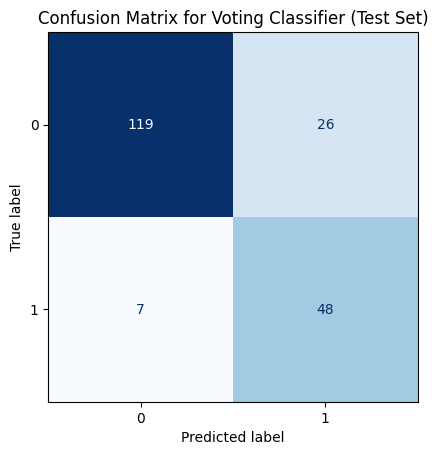

        Classification Report for Voting Classifier         
              precision  recall  f1-score  support
0                  0.94    0.82      0.88   145.00
1                  0.65    0.87      0.74    55.00
accuracy           0.83    0.83      0.83     0.83
macro avg          0.80    0.85      0.81   200.00
weighted avg       0.86    0.83      0.84   200.00


In [ ]:
# voting classifier using lda, ridge svc, adaboost, and smotetom dataset
voting_clf = VotingClassifier(
    estimators=[
        ('lda', LinearDiscriminantAnalysis(shrinkage = None, solver = 'svd')),
        #('ridge', RidgeClassifier(alpha = 0.01, solver =  'auto')),
        ('adaboost', AdaBoostClassifier(algorithm = 'SAMME', learning_rate = 0.1, n_estimators = 300)),
        ('Logistic Regression', LogisticRegression(C= 1, l1_ratio= 0, penalty='l1', solver='liblinear'))
    ],
    voting='soft'  # Majority voting
)

# Fit the voting classifier on the SMOTETomek resampled training set
voting_clf.fit(X_train_smotetom, y_train_smotetom)
# Predict on the original test set
y_pred_test_voting = voting_clf.predict(X_test)
# Calculate F1 score
test_f1_voting = f1_score(y_test, y_pred_test_voting, average='weighted')
print(f"Voting Classifier Test Weighted F1 Score: {test_f1_voting:.4f}")
# Confusion Matrix for the voting classifier on the test set
cm_test_voting = confusion_matrix(y_test, y_pred_test_voting)
try:
    disp_test_voting = ConfusionMatrixDisplay(confusion_matrix=cm_test_voting, display_labels=voting_clf.classes_)
except AttributeError:
    disp_test_voting = ConfusionMatrixDisplay(confusion_matrix=cm_test_voting)
disp_test_voting.plot(cmap='Blues', colorbar=False)
plt.title("Confusion Matrix for Voting Classifier (Test Set)")
plt.grid(False)
plt.show()
# Classification Report for the voting classifier on the test set
report_voting = classification_report(y_test, y_pred_test_voting, output_dict=True)
print("=" * 60)
print(f"{'Classification Report for Voting Classifier':^60}")
print("=" * 60)
df_report_voting = pd.DataFrame(report_voting).transpose()
print(df_report_voting)

Voting Classifier Test Weighted F1 Score: 0.8414


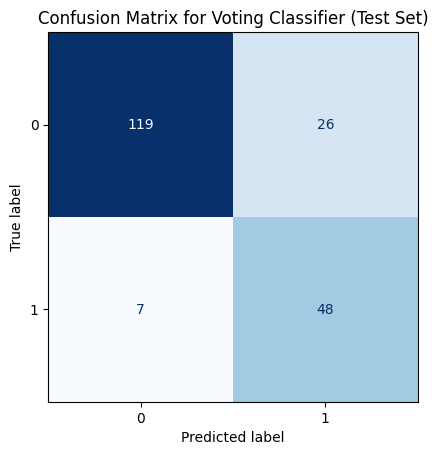

        Classification Report for Voting Classifier         
              precision  recall  f1-score  support
0                  0.94    0.82      0.88   145.00
1                  0.65    0.87      0.74    55.00
accuracy           0.83    0.83      0.83     0.83
macro avg          0.80    0.85      0.81   200.00
weighted avg       0.86    0.83      0.84   200.00


In [ ]:
# voting classifier using lda, ridge svc, adaboost, and smotetom dataset
voting_clf = VotingClassifier(
    estimators=[
        ('lda', LinearDiscriminantAnalysis(shrinkage = None, solver = 'svd')),
        ('ridge', RidgeClassifier(alpha = 0.01, solver =  'auto')),
        ('adaboost', AdaBoostClassifier(algorithm = 'SAMME', learning_rate = 0.1, n_estimators = 300)),
        ('Logistic Regression', LogisticRegression(C= 1, l1_ratio= 0, penalty='l1', solver='liblinear'))
        

    ],
    voting='hard'  # Majority voting
)

# Fit the voting classifier on the SMOTETomek resampled training set
voting_clf.fit(X_train_smotetom, y_train_smotetom)
# Predict on the original test set
y_pred_test_voting = voting_clf.predict(X_test)
# Calculate F1 score
test_f1_voting = f1_score(y_test, y_pred_test_voting, average='weighted')
print(f"Voting Classifier Test Weighted F1 Score: {test_f1_voting:.4f}")
# Confusion Matrix for the voting classifier on the test set
cm_test_voting = confusion_matrix(y_test, y_pred_test_voting)
try:
    disp_test_voting = ConfusionMatrixDisplay(confusion_matrix=cm_test_voting, display_labels=voting_clf.classes_)
except AttributeError:
    disp_test_voting = ConfusionMatrixDisplay(confusion_matrix=cm_test_voting)
disp_test_voting.plot(cmap='Blues', colorbar=False)
plt.title("Confusion Matrix for Voting Classifier (Test Set)")
plt.grid(False)
plt.show()
# Classification Report for the voting classifier on the test set
report_voting = classification_report(y_test, y_pred_test_voting, output_dict=True)
print("=" * 60)
print(f"{'Classification Report for Voting Classifier':^60}")
print("=" * 60)
df_report_voting = pd.DataFrame(report_voting).transpose()
print(df_report_voting)